In [363]:
## Import dependencies.
import os
import itertools
from scipy.io import loadmat, savemat, matlab
import scipy.stats as stt
import numpy as np
import pandas as pd
import numpy.matlib
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import seaborn as sns
#from mpl_toolkits.axes_grid1 import make_axes_locatable
from collections import Counter

## Check whether simple_colors is installed, otherwise install using pip
try:
    from simple_colors import * # for printing colored and bold text
except:
    ! pip install simple_colors

## Import simple_colors
from simple_colors import *

## Flags.
save_figures_flag = False
sample_groupsize = 'matched' # Valid options: 'matched', 'all subjects'
# Flag 1
quick_optimize_flag = False
if quick_optimize_flag:
    epsilon_C = 0.001
else:
    epsilon_C = 0.0001
FC_scale = 'standard_scale' # Options: 'max_scale', 'standard_scale'
# Flag 2
io_based_on_nodal_degree_flag = False
# Flag 3
allow_all_connections_for_EC_flag = False
# Flag 4
optimize_with_FC_version = 'ts_scaled' # Options: 'FC_scaled','FC', 'ts_scaled'
# Flag 5
input_is_rowsum_flag = True # If == False, input = columnsum
# Flag 6
scale_ts_flag = True

## Introduce constants.
_FIGURES_DIR = 'subjectwise_total_analysis_figures'
_RES_DIR = str(
    'flag1-' + str(int(quick_optimize_flag)) +
    ' flag2-' + str(int(io_based_on_nodal_degree_flag)) +
    ' flag3-' + str(int(allow_all_connections_for_EC_flag)) +
    ' flag4-' + str(optimize_with_FC_version) +
    ' flag5-' + str(int(input_is_rowsum_flag)) +
    ' flag6-' + str(int(scale_ts_flag)) + '/')
# EC mit min_val_C = -3 (und ganz normal max_val_C = 3)
#_RES_DIR = str(
#    'flag1-' + str(int(quick_optimize_flag)) +
#    ' flag2-' + str(int(io_based_on_nodal_degree_flag)) +
#    ' flag3-' + str(int(allow_all_connections_for_EC_flag)) +
#    ' flag4-' + str(optimize_with_FC_version) +
#    ' flag5-' + str(int(input_is_rowsum_flag)) +
#    ' flag6-' + str(int(scale_ts_flag)) +
#    ' min_val_C--3' + '/')
_I_REST_RUN = 0
_I_NBACK_RUN = 1
_I_NO_TIMESHIFT = 0
_I_ONE_TIMESHIFT = 1
_SUBJECT_AXIS = 0
seed = 0 # None

suptitle_fontsize = 25
title_fontsize = 24
axis_lable_fontsize = 16
fontsize = 15
top_adjust = 0.88

## Create a local folder to store results.
if not os.path.exists(_RES_DIR):
    print('created directory:', _RES_DIR)
    os.makedirs(_RES_DIR)
if not os.path.exists(_FIGURES_DIR):
    print('created directory:', _FIGURES_DIR)
    os.makedirs(_FIGURES_DIR)

In [364]:
## Examine input and output to and from RC regions.
def calculate_rc_total_input_and_output(
    C, input_is_rowsum=input_is_rowsum_flag):
    """This function calculates the sum total of incoming and outgoing EC for
    each region.
    
    """

    if input_is_rowsum:
        input_axis = 0
        output_axis = 1
    else:
        input_axis = 1
        output_axis = 0

    if io_based_on_nodal_degree_flag:
        input_rois = np.squeeze(
            np.count_nonzero(C, axis=input_axis, keepdims=True))
        output_rois = np.squeeze(
            np.count_nonzero(C, axis=output_axis, keepdims=True))
    else:
        input_rois = C[:, :].sum(axis=input_axis)
        output_rois = C[:, :].sum(axis=output_axis)
    return input_rois, output_rois

In [365]:
def examine_significance(data_patients, data_controls, 
                         statistic_patients, statistic_controls,
                         statistic_description, y_labels,
                         roi_indexes, alpha, stat_fun):
    """ This function basically performs a permutation test to 
    (for each region) determin the significance of some statistic,
    which is defined by the parameter 'stat_fun'. 
    
    The statistic for the patient and the control group both have
    to be passed through 'statistic_patients' and 'statistic_controls'. 
    'data_patients' and 'data_controls' denote the data for which the statistic
    is calculated. The index-samples called 'group_samples' have to be sampled
    before the call of this function. Also, the indexes for the rc
    'indexes_rc', and for the lobes ('indexes_frontal', etc.) are assumed to 
    be known/exist as variable by the time this function is called.
    Significant (with the significance level of 'alpha') values are marked 
    green, while values within the CI are marked red.
    """
    n_samples, n_subjects = group_samples.shape
    y_labels = y_labels[roi_indexes]
    statistic_patients = statistic_patients[roi_indexes]
    statistic_controls = statistic_controls[roi_indexes]
    if sample_groupsize== 'matched':
        data_patients = data_patients[:n_subjects, roi_indexes]
        data_controls = data_controls[:n_subjects, roi_indexes]
        distribution = np.concatenate((data_patients, data_controls),
                                     axis=0)
    else:
        distribution = np.concatenate(
            (data_patients[:, roi_indexes], data_controls[:, roi_indexes]),
            axis=0)
        
    frontal_start = 0
    frontal_end = len(indexes_frontal) - 1
    parietal_start = frontal_end + 1
    parietal_end = parietal_start + len(indexes_parietal) - 1
    temporal_start = parietal_end + 1
    temporal_end = temporal_start + len(indexes_temporal) - 1
    occipital_start = temporal_end + 1
    occipital_end = occipital_start + len(indexes_occipital) - 1
    cingulate_start = occipital_end + 1
    cingulate_end = cingulate_start + len(indexes_cingulate) - 1
    
    groups = np.array([distribution[group_sample.astype(int), :]
                                          for group_sample in group_samples])
    alpha = alpha # alpha percentile
    lower_limit = int(np.floor(n_samples * (1 - alpha) / 2))
    upper_limit = int(np.floor(n_samples * (1 + alpha) / 2))
    rankordered_samples = np.sort(stat_fun(groups, axis=1), axis=0)
    rankordered_samples = rankordered_samples[lower_limit:upper_limit, :]
    xerr = rankordered_samples[[0,-1], :]

    fontsize = 15
    markersize = 18
    y = np.arange(len(roi_indexes))
    fig = plt.figure(figsize=(20, len(y_labels)/3))
    if len(y_labels) >= n_subjects:
        plt.rcParams['axes.ymargin'] = 0.01
    else:
        plt.rcParams['axes.ymargin'] = 0.2
    ax1 = plt.subplot(121)

    plt.hlines(np.matlib.repmat(y, 2, 1), xmin=xerr[0], xmax=xerr[1], color='b')
    plt.plot(xerr, np.matlib.repmat(y, 2, 1), '|', color='b', markersize=10)
    plt.plot(rankordered_samples.mean(axis=0), y, '|', color='b', markersize=5)
    
    for i_rc_roi in range(len(roi_indexes)):
        i_statistic_patients = statistic_patients[i_rc_roi]
        format_string = '.r'
        if (i_statistic_patients > xerr.T[i_rc_roi,1] or
            i_statistic_patients < xerr.T[i_rc_roi,0]):
            format_string = '.g' 
        plt.plot(i_statistic_patients, y_labels[i_rc_roi],
                 format_string, markersize=markersize)
    
    if not((indexes_rc >= len(roi_indexes)).any()):
        # Emphsize rc labels
        rc_indexes = list(list(
            roi_labels_categorized).index(i_label) for i_label in labels_rc)
        [tick.label.set_fontsize(fontsize) for tick in 
         map(ax1.yaxis.get_major_ticks().__getitem__, rc_indexes)]

        [tick.label.set_color('green') for tick in 
         map(ax1.yaxis.get_major_ticks().__getitem__,
             np.linspace(frontal_start, frontal_end, len(indexes_frontal), dtype=int))]
    #    [tick.label.set_color('black') for tick in 
    #     map(ax1.yaxis.get_major_ticks().__getitem__,
    #         np.linspace(parietal_start, parietal_end, len(indexes_parietal), dtype=int))]
        [tick.label.set_color('green') for tick in 
         map(ax1.yaxis.get_major_ticks().__getitem__,
             np.linspace(temporal_start, temporal_end, len(indexes_temporal), dtype=int))]
    #    [tick.label.set_color('black') for tick in 
    #     map(ax1.yaxis.get_major_ticks().__getitem__,
    #         np.linspace(occipital_start, occipital_end, len(indexes_occipital), dtype=int))]
        [tick.label.set_color('green') for tick in 
         map(ax1.yaxis.get_major_ticks().__getitem__,
             np.linspace(cingulate_start, cingulate_end, len(indexes_cingulate), dtype=int))]

   
        
    #    [tl.set_backgroundcolor('C3') for tl in 
    #     map(ax1.get_yticklabels().__getitem__, indexes_rc)]
    
    #plt.yticks(fontsize=20)
    #ax1.set_ylabel('Y axis', fontsize = fontsize)
    #for tick in ax1.yaxis.get_major_ticks() if tick in indexes_rc:
    #    tick.label.set_fontsize(fontsize)
    plt.title(statistic_description + ' for patients',
              fontsize=title_fontsize)
    #plt.show()

    #fig = plt.figure()
    ax2 = plt.subplot(122)
    ax2.yaxis.tick_right()
    plt.hlines(np.matlib.repmat(y, 2, 1), xmin=xerr[0], xmax=xerr[1], color='b')
    plt.plot(xerr, np.matlib.repmat(y, 2, 1), '|', color='b', markersize=10)
    plt.plot(rankordered_samples.mean(axis=0), y, '|', color='b', markersize=5)
    
    
    for i_rc_roi in range(len(roi_indexes)):
        i_statistic_controls = statistic_controls[i_rc_roi]
        format_string = '.r'
        if (i_statistic_controls > xerr.T[i_rc_roi,1] or
            i_statistic_controls < xerr.T[i_rc_roi,0]):
            format_string = '.g' 
        plt.plot(i_statistic_controls, y_labels[i_rc_roi],
                 format_string, markersize=markersize)
        
    if not((indexes_rc >= len(roi_indexes)).any()):
        # Emphsize rc labels
        [label.set_fontsize(fontsize) for label in 
         map(ax2.yaxis.get_majorticklabels().__getitem__, rc_indexes)]

        [label.set_color('green') for label in 
         map(ax2.yaxis.get_majorticklabels().__getitem__,
             np.linspace(frontal_start, frontal_end, len(indexes_frontal), dtype=int))]
    #    [label.set_color('black') for label in 
    #     map(ax2.yaxis.get_majorticklabels().__getitem__,
    #         np.linspace(parietal_start, parietal_end, len(indexes_parietal), dtype=int))]
        [label.set_color('green') for label in 
         map(ax2.yaxis.get_majorticklabels().__getitem__,
             np.linspace(temporal_start, temporal_end, len(indexes_temporal), dtype=int))]
    #    [label.set_color('black') for label in 
    #     map(ax2.yaxis.get_majorticklabels().__getitem__,
    #         np.linspace(occipital_start, occipital_end, len(indexes_occipital), dtype=int))]
        [label.set_color('green') for label in 
         map(ax2.yaxis.get_majorticklabels().__getitem__,
             np.linspace(cingulate_start, cingulate_end, len(indexes_cingulate), dtype=int))]
    
    #ax2.yaxis.tick_right()
    #ax2.yaxis.set_label_position("right")
    #ax2.yaxis.tick_labels(y_labels)
    #ax2.yaxis.tick_right()
    #ax2.yaxis.set_ticks_position('right')
    


    plt.title(statistic_description + ' for controls',
              fontsize=title_fontsize)
    plt.tight_layout(h_pad=1)
    plt.show()
    print('Patients: The parameter value lies above the mean of the values'
          ' the parameter takes for the permuted groups for\n\t', 
          (statistic_patients > rankordered_samples.mean(axis=0)).sum(),
          'of', data_patients.shape[1], 'rois.')
    print('Controls: The parameter value lies above the mean of the values'
          ' the parameter takes for the permuted groups for\n\t', 
          (statistic_controls > rankordered_samples.mean(axis=0)).sum(),
          'of', data_patients.shape[1], 'rois.')
    print('Patients: lh values are greater than rh values for',
          (statistic_patients[0::2] > statistic_patients[1::2]).sum(),
          'of', int(len(roi_indexes)/2), 'rois.')
    print('Controls: lh values are greater than rh values for',
          (statistic_controls[0::2] > statistic_controls[1::2]).sum(),
          'of', int(len(roi_indexes)/2), 'rois.')
    print("The mean of the patient's values are smaller than the control's"
         " for", (statistic_patients < statistic_controls).sum(), "rois.")
    print("For the frontal lobe it is smaller for", 
          (statistic_patients[frontal_start:frontal_end]
           < statistic_controls[frontal_start:frontal_end]).sum(), "of", 
         frontal_end+1, "rois.")
    print("For the temporal lobe it is smaller for", 
          (statistic_patients[temporal_start-1:temporal_end]
           < statistic_controls[temporal_start-1:temporal_end]).sum(), "of", 
         len(indexes_temporal), "rois.")
    print("For the parietal lobe it is smaller for", 
          (statistic_patients[parietal_start-1:parietal_end]
           < statistic_controls[parietal_start-1:parietal_end]).sum(), "of", 
         len(indexes_parietal), "rois.")
    print("For the occipital lobe it is smaller for", 
          (statistic_patients[occipital_start-1:occipital_end]
           < statistic_controls[occipital_start-1:occipital_end]).sum(), "of", 
         len(indexes_occipital), "rois.")
    print("For the cingulate lobe it is smaller for", 
          (statistic_patients[cingulate_start-1:cingulate_end]
           < statistic_controls[cingulate_start-1:cingulate_end]).sum(), "of", 
         len(indexes_cingulate), "rois.")
    return fig

In [366]:
#def plot_feeder_io_group_comparing_boxplot(input_patients, output_patients,
def plot_input_output_boxplot(input_patients, output_patients,
                              input_controls, output_controls, cmap):
    max_input = np.append(input_patients, input_controls).max()+1
    min_input = np.append(input_patients, input_controls).min()-1
    max_output = np.append(output_patients, output_controls).max()+1
    min_output = np.append(output_patients, output_controls).min()-1
    
    NUM_COLORS = max([len(input_Counter_subjects_total_patients),
                      len(input_Counter_subjects_total_controls),
                      len(input_Counter_subjects_total_controls),
                      len(output_Counter_subjects_total_patients)])
    cm = plt.get_cmap(cmap)
    
    fig_input = plt.figure(figsize=(14, 10))
    plt.suptitle('Input', fontsize=suptitle_fontsize)
    plt.subplots_adjust(top=top_adjust)
    ax = plt.subplot(121)
    NUM_COLORS = len(input_Counter_subjects_total_patients)
    ax.set_prop_cycle('color', [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
    plt.title('Patient', fontsize=title_fontsize)
    plt.ylabel('region', fontsize=axis_lable_fontsize)
    plt.xlabel('input', fontsize=axis_lable_fontsize)
    plt.xlim(min_input, max_input)
    n_rois = input_patients.shape[1]
    plt.boxplot(input_patients, positions = np.arange(n_rois), vert=False)
    
    #[plt.scatter(input_patients[max_ind], np.arange(n_rois), s=50, marker='o')
    # for max_ind in sorted(input_Counter_subjects_total_patients)]
    [plt.plot(input_patients[max_ind], np.arange(n_rois), markersize=7, 
              marker='o', linestyle='None', label=str(max_ind))
              for max_ind in sorted(input_Counter_subjects_total_patients)]
    plt.legend(title='subject index')
    ax = plt.subplot(122)
    NUM_COLORS = len(input_Counter_subjects_total_controls)
    ax.set_prop_cycle('color', [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
    plt.title('Control', fontsize=title_fontsize)
    plt.ylabel('region', fontsize=axis_lable_fontsize)
    plt.xlabel('input', fontsize=axis_lable_fontsize)
    plt.xlim(min_input, max_input)
    n_rois = input_controls.shape[1]
    plt.boxplot(input_controls, positions = np.arange(n_rois), vert=False)
    
    #[plt.scatter(input_controls[max_ind], np.arange(n_rois), s=50, marker='o')
    # for max_ind in sorted(input_Counter_subjects_total_controls)]
    [plt.plot(input_controls[max_ind], np.arange(n_rois), markersize=7, 
              marker='o', linestyle='None', label=str(max_ind))
              for max_ind in sorted(input_Counter_subjects_total_controls)]
    plt.legend(title='subject index')
    plt.show()
    fig_output = plt.figure(figsize=(14, 10))
    plt.suptitle('Output', fontsize=suptitle_fontsize)
    plt.subplots_adjust(top=top_adjust)
    ax = plt.subplot(121)
    NUM_COLORS = len(output_Counter_subjects_total_patients)
    ax.set_prop_cycle('color', [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
    plt.title('Patient', fontsize=title_fontsize)
    plt.ylabel('region', fontsize=axis_lable_fontsize)
    plt.xlabel('output', fontsize=axis_lable_fontsize)
    plt.xlim(min_output, max_output)
    n_rois = output_patients.shape[1]
    plt.boxplot(output_patients, positions = np.arange(n_rois), vert=False)
    
    #[plt.scatter(output_patients[max_ind], np.arange(n_rois), s=50, marker='o')
    # for max_ind in sorted(output_Counter_subjects_total_patients)]
    [plt.plot(output_patients[max_ind], np.arange(n_rois), markersize=7, 
              marker='o', linestyle='None', label=str(max_ind))
              for max_ind in sorted(output_Counter_subjects_total_patients)]
    plt.legend(title='subject index')
    ax = plt.subplot(122)
    NUM_COLORS = len(output_Counter_subjects_total_controls)
    ax.set_prop_cycle('color', [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
    plt.title('Control', fontsize=title_fontsize)
    plt.ylabel('region', fontsize=axis_lable_fontsize)
    plt.xlabel('output', fontsize=axis_lable_fontsize)
    plt.xlim(min_output, max_output)
    n_rois = output_controls.shape[1]
    plt.boxplot(output_controls, positions = np.arange(n_rois), vert=False)
    
    #[plt.scatter(output_controls[max_ind], np.arange(n_rois), s=50, marker='o')
    # for max_ind in sorted(output_Counter_subjects_total_controls)]
    [plt.plot(output_controls[max_ind], np.arange(n_rois), markersize=7, 
              marker='o', linestyle='None', label=str(max_ind))
              for max_ind in sorted(output_Counter_subjects_total_controls)]
    plt.legend(title='subject index')
    plt.show()
    return fig_input, fig_output

In [367]:
## Examine io ratio of RC regions.
def plot_rc_io_ratio(io_ratio_rc_patients, io_ratio_rc_controls,
                     indexes_rc):
    plt.figure(figsize=(32, 10))
    plt.subplot(121)
    plt.title('Patients', fontsize=suptitle_fontsize)
    plt.subplots_adjust(top=top_adjust)
    n_rois = io_ratio_rc_patients.shape[1]
    plt.boxplot(io_ratio_rc_patients, positions = np.arange(n_rois),
                vert=False)
    plt.ylabel('region', fontsize=axis_lable_fontsize)
    plt.yticks(np.arange(n_rois), roi_labels[indexes_rc],
           fontsize=fontsize)
    plt.xlabel('io ratio', fontsize=axis_lable_fontsize)
    plt.subplot(122)
    plt.title('Controls', fontsize=suptitle_fontsize)
    n_rois = io_ratio_rc_controls.shape[1]
    plt.boxplot(io_ratio_rc_controls, positions = np.arange(n_rois),
                vert=False)
    plt.yticks(np.arange(n_rois), roi_labels[indexes_rc],
           fontsize=fontsize)
    plt.xlabel('io ratio', fontsize=axis_lable_fontsize)
    plt.show()

In [368]:
# Load EC per subject for patients & control group.
C_patients_dict = np.load(_RES_DIR + 'C_patients_dict.npy', allow_pickle=True).tolist()
C_controls_dict = np.load(_RES_DIR + 'C_controls_dict.npy', allow_pickle=True).tolist()
# Load parametes.
parameter_dict = np.load(_RES_DIR + 'parameter_dict.npy', allow_pickle=True).tolist()
roi_labels = parameter_dict['roi_labels']
mask_EC = parameter_dict['mask_EC']
group_samples = np.load(_RES_DIR + 'group_samples.npy')
J_patients = np.load(_RES_DIR + 'J_patients.npy')
J_controls = np.load(_RES_DIR + 'J_controls.npy')
Sigma_patients = np.load(_RES_DIR + 'Sigma_patients.npy')
Sigma_controls = np.load(_RES_DIR + 'Sigma_controls.npy')
dist_patients = np.load(_RES_DIR + 'dist_patients.npy')
dist_controls = np.load(_RES_DIR + 'dist_controls.npy')
R2_patients = np.load(_RES_DIR + 'R2_patients.npy')
R2_controls = np.load(_RES_DIR + 'R2_controls.npy')
C_patients = C_patients_dict['C_mod']
C_controls = C_controls_dict['C_mod']
print('epsilon_C =', C_patients_dict['epsilon_C'])

epsilon_C = 0.0001


In [369]:
## Calculate the feeder input and output.
# Define constants.
n_patients, n_rois, _ = C_patients.shape
n_controls, _, _ = C_controls.shape
# Define RC.
rc_labels = ['precuneus', 'superiorfrontal', 'superiorparietal']
mask_rc = np.zeros(n_rois, dtype=bool)
for i_rc_label in rc_labels:
    mask_rc[np.frompyfunc(lambda x: i_rc_label in x, 1, 1)(roi_labels).astype(
        bool)] = True
labels_rc = roi_labels[mask_rc]
indexes_rc = np.array(*np.where(mask_rc))
print(black('Rich club regions:\n', 'bold'), roi_labels[mask_rc].tolist())

[input_patients, output_patients] = np.squeeze(np.split(
    np.array([ calculate_rc_total_input_and_output(x) for x in C_patients ]),
    2, axis=1))

[input_controls, output_controls] = np.squeeze(np.split(
    np.array([ calculate_rc_total_input_and_output(x) for x in C_controls ]),
    2, axis=1))

Rich club regions:
 ['lh_precuneus', 'lh_superiorfrontal', 'lh_superiorparietal', 'rh_precuneus', 'rh_superiorfrontal', 'rh_superiorparietal']


In [370]:
# lobe-mapping according to (insula counted to temporal (Wikipedia)):
# https://surfer.nmr.mgh.harvard.edu/fswiki/CorticalParcellation
print_labels_flag = True

frontal_labels = ['frontal', 'pars', 'precentral', 'paracentral']
mask_frontal = np.zeros(n_rois, dtype=bool)
for i_label in frontal_labels:
    mask_frontal[np.frompyfunc(lambda x: i_label in x, 1, 1)(roi_labels).astype(
        bool)] = True
indexes_frontal = np.array(*np.where(mask_frontal))

parietal_labels = ['parietal', 'supramarginal', 'postcentral', 'precuneus']
mask_parietal = np.zeros(n_rois, dtype=bool)
for i_label in parietal_labels:
    mask_parietal[np.frompyfunc(lambda x: i_label in x, 1, 1)(roi_labels).astype(
        bool)] = True
indexes_parietal = np.array(*np.where(mask_parietal))

temporal_labels = ['temporal', 'banks', 'fusiform', 'entorhinal',
                   'parahippocampal']
mask_temporal = np.zeros(n_rois, dtype=bool)
for i_label in temporal_labels:
    mask_temporal[np.frompyfunc(lambda x: i_label in x, 1, 1)(roi_labels).astype(
        bool)] = True
indexes_temporal = np.array(*np.where(mask_temporal))

occipital_labels = ['occipital', 'lingual', '_cuneus', 'pericalcarine']
mask_occipital = np.zeros(n_rois, dtype=bool)
for i_label in occipital_labels:
    mask_occipital[np.frompyfunc(lambda x: i_label in x, 1, 1)(roi_labels).astype(
        bool)] = True
indexes_occipital = np.array(*np.where(mask_occipital))

cingulate_labels = ['cingulate']
mask_cingulate = np.zeros(n_rois, dtype=bool)
for i_label in cingulate_labels:
    mask_cingulate[np.frompyfunc(lambda x: i_label in x, 1, 1)(roi_labels).astype(
        bool)] = True
indexes_cingulate = np.array(*np.where(mask_cingulate))


# Here follows the categorization with every roi followed by same roi of other hemisphere.
indexes_lh = np.zeros(0, dtype=int)
for i_label in frontal_labels:
    new_indexes = np.array(*np.where(np.frompyfunc(
        lambda x: i_label in x, 1, 1)(roi_labels[:int(n_rois/2)])))
    indexes_lh = np.append(indexes_lh, new_indexes)
indexes_frontal = np.zeros(2 * len(indexes_lh), dtype=int)
indexes_frontal[0::2] = indexes_lh
indexes_frontal[1::2] = indexes_lh + n_rois/2    
    
indexes_lh = np.zeros(0, dtype=int)
for i_label in parietal_labels:
    new_indexes = np.array(*np.where(np.frompyfunc(
        lambda x: i_label in x, 1, 1)(roi_labels[:int(n_rois/2)])))
    indexes_lh = np.append(indexes_lh, new_indexes)
indexes_parietal = np.zeros(2 * len(indexes_lh), dtype=int)
indexes_parietal[0::2] = indexes_lh
indexes_parietal[1::2] = indexes_lh + n_rois/2

indexes_lh = np.zeros(0, dtype=int)
for i_label in temporal_labels:
    new_indexes = np.array(*np.where(np.frompyfunc(
        lambda x: i_label in x, 1, 1)(roi_labels[:int(n_rois/2)])))
    indexes_lh = np.append(indexes_lh, new_indexes)
indexes_temporal = np.zeros(2 * len(indexes_lh), dtype=int)
indexes_temporal[0::2] = indexes_lh
indexes_temporal[1::2] = indexes_lh + n_rois/2

indexes_lh = np.zeros(0, dtype=int)
for i_label in cingulate_labels:
    new_indexes = np.array(*np.where(np.frompyfunc(
        lambda x: i_label in x, 1, 1)(roi_labels[:int(n_rois/2)])))
    indexes_lh = np.append(indexes_lh, new_indexes)
indexes_cingulate = np.zeros(2 * len(indexes_lh), dtype=int)
indexes_cingulate[0::2] = indexes_lh
indexes_cingulate[1::2] = indexes_lh + n_rois/2

indexes_lh = np.zeros(0, dtype=int)
for i_label in occipital_labels:
    new_indexes = np.array(*np.where(np.frompyfunc(
        lambda x: i_label in x, 1, 1)(roi_labels[:int(n_rois/2)])))
    indexes_lh = np.append(indexes_lh, new_indexes)
indexes_occipital = np.zeros(2 * len(indexes_lh), dtype=int)
indexes_occipital[0::2] = indexes_lh
indexes_occipital[1::2] = indexes_lh + n_rois/2

indexes_insula = np.array(
    *np.where(np.frompyfunc(lambda x: 'insula' in x, 1, 1)(roi_labels)))

if print_labels_flag:
    print('frontal:', roi_labels[indexes_frontal])
    print('parietal:', roi_labels[indexes_parietal])
    print('temporal:', roi_labels[indexes_temporal])
    print('occipital:', roi_labels[indexes_occipital])
    print('cingulate:', roi_labels[indexes_cingulate])

roi_indexes_categorized = [*indexes_frontal, *indexes_parietal,
                           *indexes_temporal, *indexes_occipital,
                           *indexes_cingulate, *indexes_insula]
roi_labels_categorized = roi_labels[roi_indexes_categorized]
indexes_rc_categorized = list(list(roi_labels_categorized).index(i_label)
                              for i_label in labels_rc)

#rc_labels = ['precuneus', 'superiorfrontal', 'superiorparietal']
#mask_rc = np.zeros(n_rois, dtype=bool)
#for i_rc_label in rc_labels:
#    mask_rc[np.frompyfunc(lambda x: i_rc_label in x, 1, 1)(
#        roi_labels_categorized).astype(bool)] = True
#indexes_rc_categorized = np.array(*np.where(mask_rc), dtype=int)

temp = np.zeros(len(indexes_rc), dtype=int)
temp[0::2] = indexes_rc[0:3]
temp[1::2] = indexes_rc[3:6]
indexes_rc = temp

input_patients_categorized = input_patients[:, roi_indexes_categorized]
output_patients_categorized = output_patients[:, roi_indexes_categorized]
input_controls_categorized = input_controls[:, roi_indexes_categorized]
output_controls_categorized = output_controls[:, roi_indexes_categorized]

#list(list(roi_labels_categorized).index(i_label) for i_label in labels_rc)
#np.concatenate((indexes_rc[0:3], indexes_rc[3:6]))
#np.array(*np.where(np.frompyfunc(lambda x: 'insula' in x, 1, 1)(roi_labels)))
#roi_labels[np.where(np.frompyfunc(lambda x: 'insula' in x, 1, 1)(roi_labels))]

frontal: ['lh_caudalmiddlefrontal' 'rh_caudalmiddlefrontal'
 'lh_lateralorbitofrontal' 'rh_lateralorbitofrontal'
 'lh_medialorbitofrontal' 'rh_medialorbitofrontal'
 'lh_rostralmiddlefrontal' 'rh_rostralmiddlefrontal' 'lh_superiorfrontal'
 'rh_superiorfrontal' 'lh_frontalpole' 'rh_frontalpole'
 'lh_parsopercularis' 'rh_parsopercularis' 'lh_parsorbitalis'
 'rh_parsorbitalis' 'lh_parstriangularis' 'rh_parstriangularis'
 'lh_precentral' 'rh_precentral' 'lh_paracentral' 'rh_paracentral']
parietal: ['lh_inferiorparietal' 'rh_inferiorparietal' 'lh_superiorparietal'
 'rh_superiorparietal' 'lh_supramarginal' 'rh_supramarginal'
 'lh_postcentral' 'rh_postcentral' 'lh_precuneus' 'rh_precuneus']
temporal: ['lh_inferiortemporal' 'rh_inferiortemporal' 'lh_middletemporal'
 'rh_middletemporal' 'lh_superiortemporal' 'rh_superiortemporal'
 'lh_temporalpole' 'rh_temporalpole' 'lh_transversetemporal'
 'rh_transversetemporal' 'lh_bankssts' 'rh_bankssts' 'lh_fusiform'
 'rh_fusiform' 'lh_entorhinal' 'rh_entor

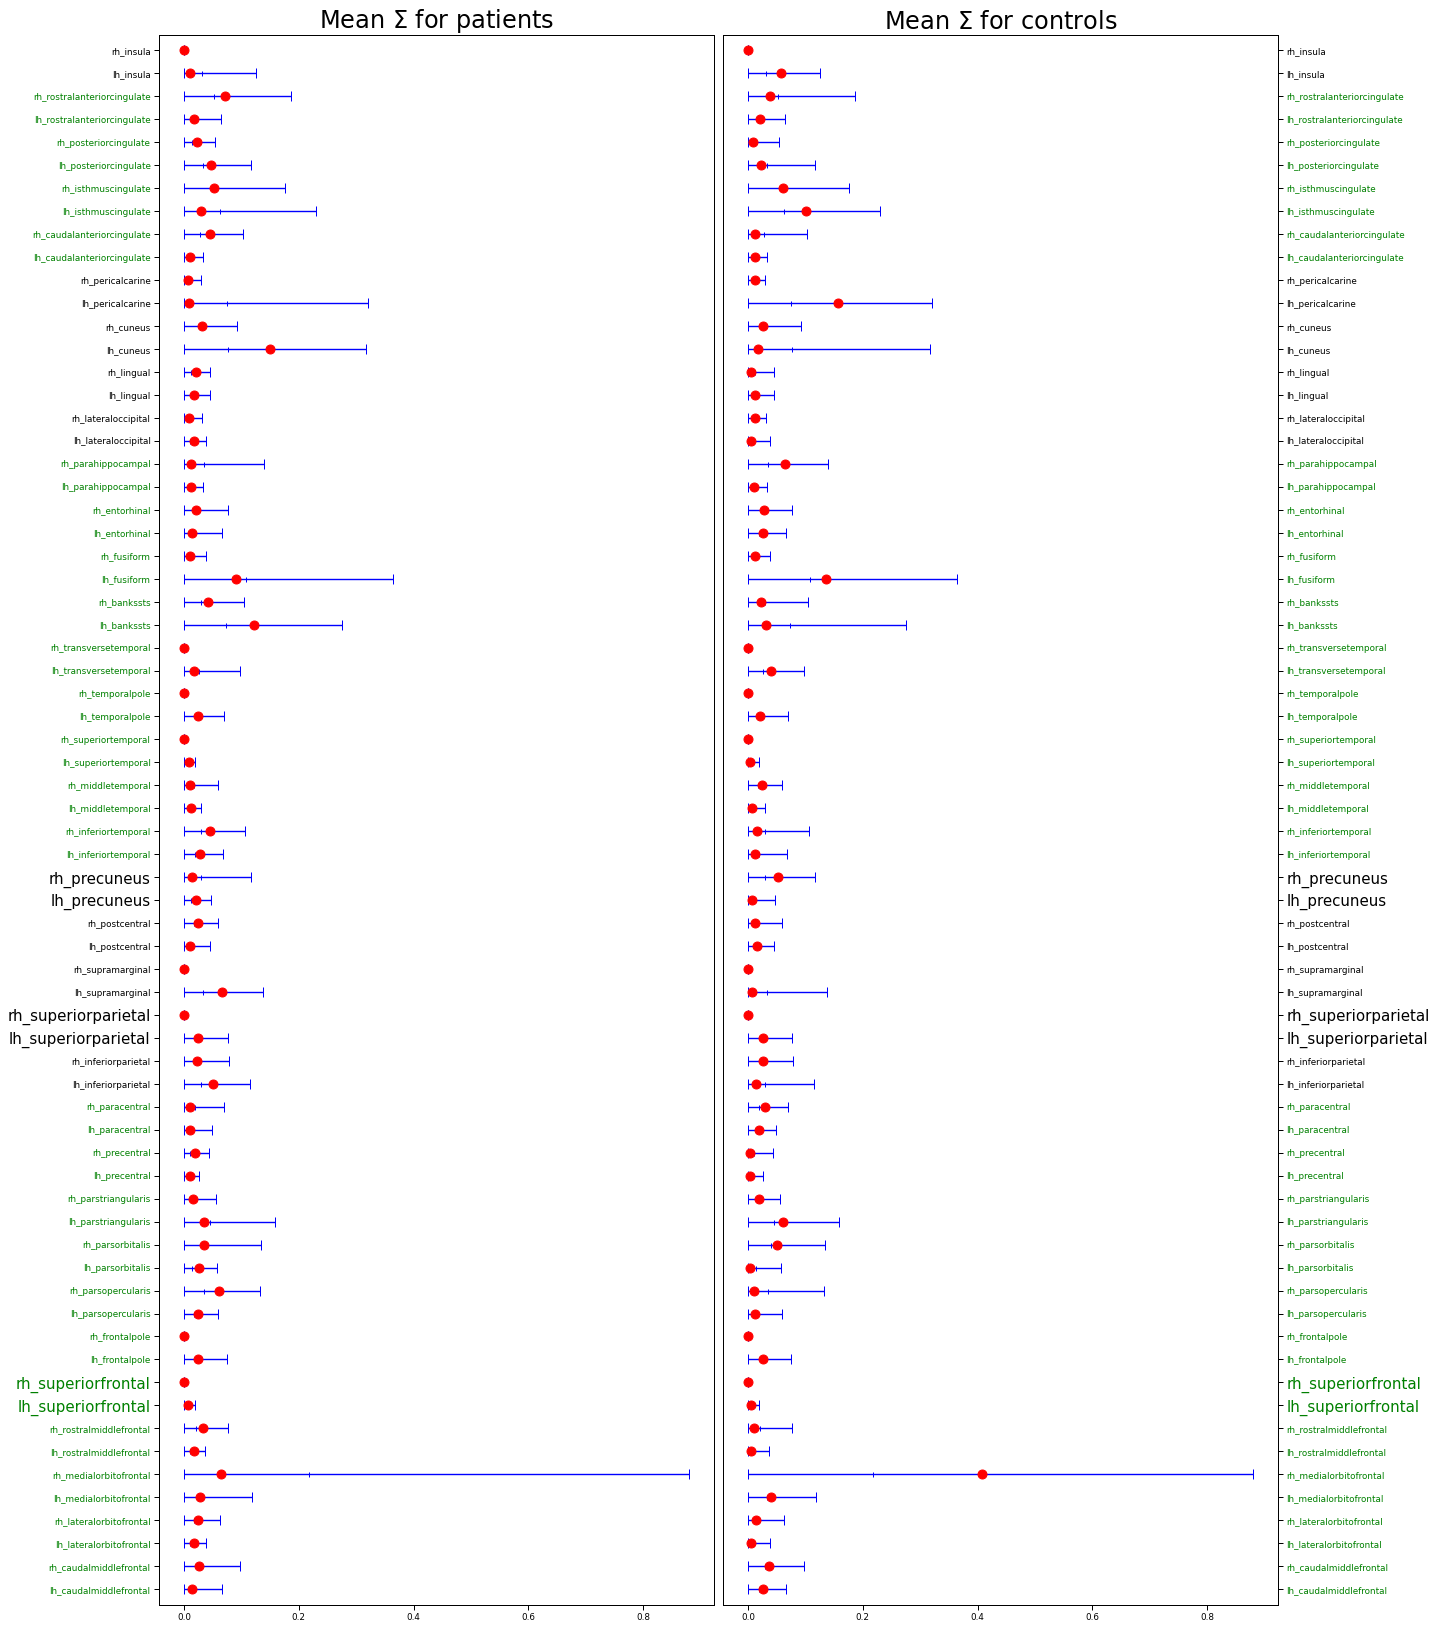

Patients: The parameter value lies above the mean of the values the parameter takes for the permuted groups for
	 33 of 68 rois.
Controls: The parameter value lies above the mean of the values the parameter takes for the permuted groups for
	 30 of 68 rois.
Patients: lh values are greater than rh values for 18 of 34 rois.
Controls: lh values are greater than rh values for 18 of 34 rois.
The mean of the patient's values are smaller than the control's for 29 rois.
For the frontal lobe it is smaller for 9 of 22 rois.
For the temporal lobe it is smaller for 7 of 18 rois.
For the parietal lobe it is smaller for 4 of 10 rois.
For the occipital lobe it is smaller for 3 of 8 rois.
For the cingulate lobe it is smaller for 5 of 8 rois.


In [371]:
## Examine significance of mean of local variance.
alpha = 0.95
statistic_description = 'Mean $\Sigma$'
y_labels = roi_labels
Sigma_patients_diag = Sigma_patients.diagonal().T
Sigma_controls_diag = Sigma_controls.diagonal().T
if sample_groupsize== 'matched':
    n_subjects = np.fmin(n_patients, n_controls)
    fig = examine_significance(Sigma_patients_diag[:n_subjects],
                               Sigma_controls_diag[:n_subjects],
                               Sigma_patients_diag[:n_subjects].mean(axis=0),
                               Sigma_controls_diag[:n_subjects].mean(axis=0),
                               statistic_description, y_labels,
                               roi_indexes_categorized, alpha, np.mean)
else:
    fig = examine_significance(Sigma_patients_diag, Sigma_controls_diag,
                               Sigma_patients_diag.mean(axis=0),
                               Sigma_controls_diag.mean(axis=0),
                               statistic_description, y_labels,
                               roi_indexes_categorized, alpha, np.mean)
if save_figures_flag:
    fig.savefig(str(_FIGURES_DIR + '/mean_all_rois_input.png'), bbox_inches='tight')

RC-indexes:
 [23 57 26 60 27 61]
Investigate input and output regionwise for RC-periphery (feeder) connections:


No handles with labels found to put in legend.
No handles with labels found to put in legend.


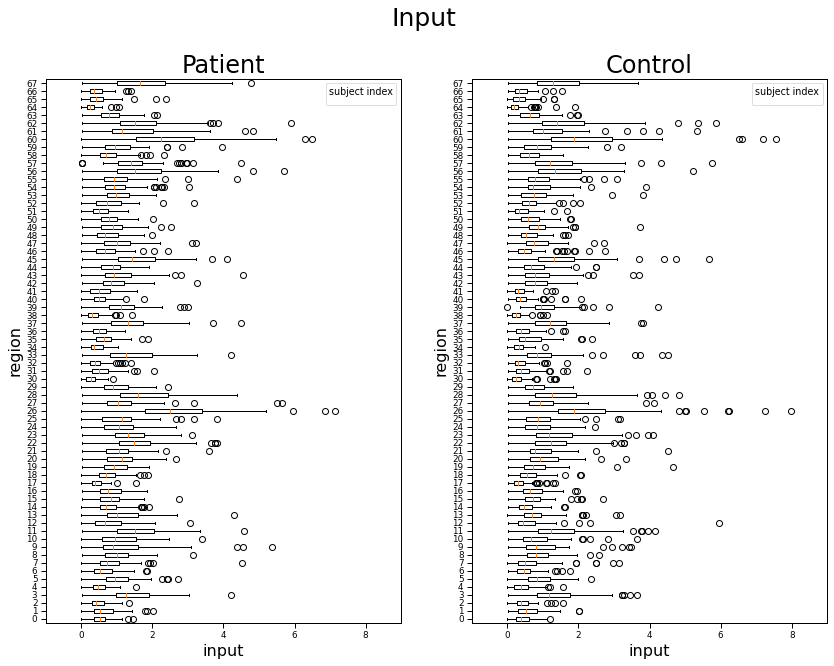

No handles with labels found to put in legend.
No handles with labels found to put in legend.


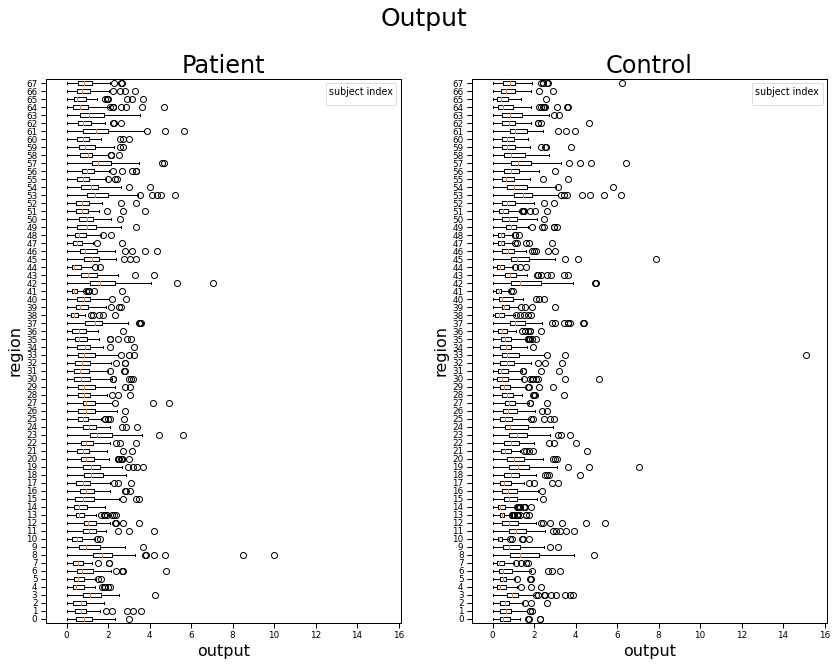

Mean rc input:	 1.0044752612765353 (patients)	 0.8809067140416044 (contols)


In [372]:
print(black('RC-indexes:\n', 'bold'), indexes_rc)
print(red('Investigate input and output regionwise for RC-periphery'
          ' (feeder) connections:', 'bold'))
#plot_feeder_io_boxplot(input_patients, output_patients, 'Patients')
#plot_feeder_io_boxplot(input_controls, output_controls, 'Controls')
input_Counter_subjects_total_patients = []
input_Counter_subjects_total_controls = []
output_Counter_subjects_total_patients = []
output_Counter_subjects_total_controls = []
plot_input_output_boxplot(
    input_patients, output_patients, input_controls, output_controls, 'jet')
print('Mean rc input:\t', input_patients.mean(),
  '(patients)\t', input_controls.mean(), '(contols)')

Input: Examine the subjects responsible for the largest value per region:
RC-indexes:
 [23 57 26 60 27 61]
Investigate input and output regionwise for RC-periphery (feeder) connections:
Patients:

input_Counter_subjects_total_patients:
 Counter({41: 12, 12: 10, 5: 9, 21: 8, 46: 7, 51: 5, 3: 3, 37: 2, 23: 2, 50: 2, 58: 1, 11: 1, 9: 1, 28: 1, 7: 1, 29: 1, 35: 1, 0: 1})

input_Counter_subjects_total_controls:
 Counter({46: 14, 8: 13, 57: 13, 64: 7, 5: 7, 48: 3, 7: 3, 38: 2, 33: 2, 19: 1, 4: 1, 21: 1, 47: 1})


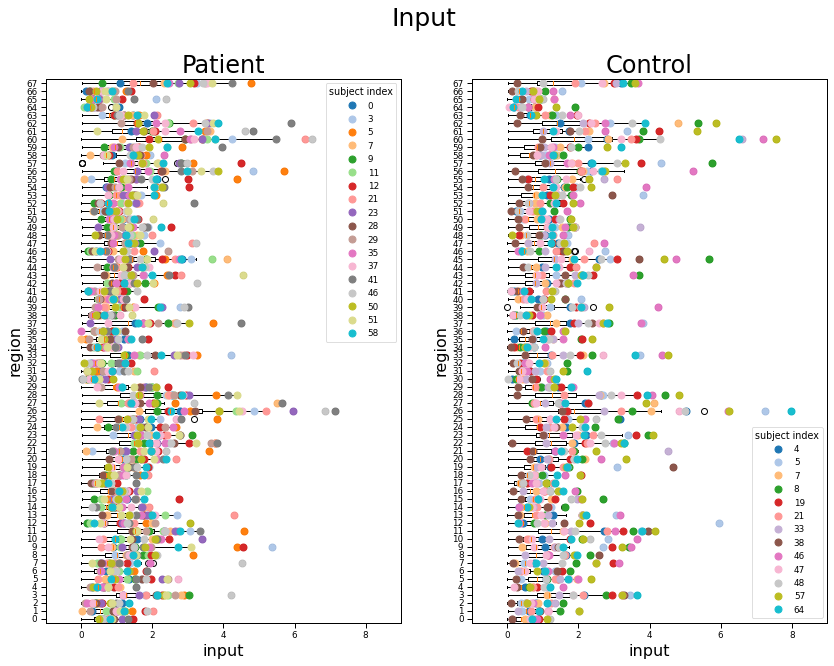

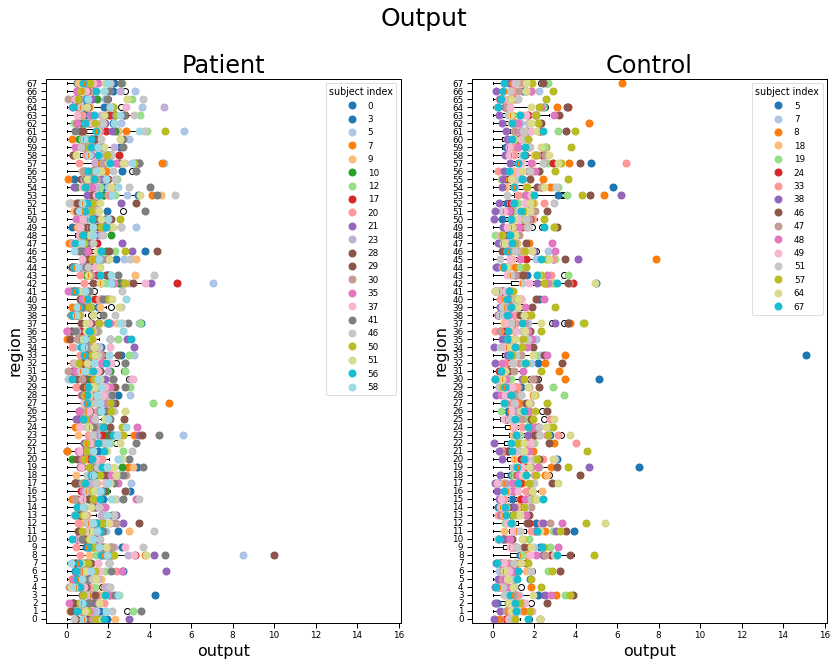

output_Counter_subjects_total_patients:
 Counter({46: 13, 5: 11, 41: 7, 12: 7, 21: 5, 29: 3, 3: 2, 9: 2, 28: 2, 35: 2, 51: 2, 58: 2, 20: 1, 0: 1, 30: 1, 7: 1, 37: 1, 56: 1, 10: 1, 50: 1, 17: 1, 23: 1})
output_Counter_subjects_total_controls:
 Counter({57: 21, 46: 12, 5: 7, 64: 5, 48: 4, 19: 4, 8: 4, 47: 2, 33: 2, 49: 1, 67: 1, 18: 1, 7: 1, 51: 1, 38: 1, 24: 1})
Mean rc input:	 1.0044752612765353 (patients)	 0.8809067140416044 (contols)


In [373]:
"""
Patients: Analyse input into rc with regard to max values. 
"""

n_max_values = 1
# Find subjects responsible for the outliers.
print(black('Input: Examine the subjects responsible for the largest value per region:', 'bold'))
input_Counter_subjects_total_patients = Counter()
input_Counter_rois_total_patients = Counter()
output_Counter_subjects_total_patients = Counter()
output_Counter_rois_total_patients = Counter()
for i_max in range(n_max_values):
    condition = input_patients.T == np.outer(np.sort(
        input_patients, axis=0)[-i_max-1, :], np.ones([n_patients]))
    input_Counter_subjects = Counter(np.asarray(condition).nonzero()[1])
    input_Counter_subjects_total_patients += input_Counter_subjects

## Analyse output with regard to max values.
# Find subjects responsible for the outliers.
for i_max in range(n_max_values):
    condition = output_patients.T == np.outer(np.sort(
        output_patients, axis=0)[-i_max-1, :], np.ones([n_patients]))
    output_Counter_subjects = Counter(np.asarray(condition).nonzero()[1])
    output_Counter_subjects_total_patients += output_Counter_subjects
    
input_Counter_subjects_total_controls = Counter()
input_Counter_rois_total_controls = Counter()
output_Counter_subjects_total_controls = Counter()
output_Counter_rois_total_controls = Counter()
for i_max in range(n_max_values):
    condition = input_controls.T == np.outer(np.sort(
        input_controls, axis=0)[-i_max-1, :], np.ones([n_controls]))
    input_Counter_subjects = Counter(np.asarray(condition).nonzero()[1])
    input_Counter_subjects_total_controls += input_Counter_subjects

## Analyse output with regard to max values.
# Find subjects responsible for the outliers.
for i_max in range(n_max_values):
    condition = output_controls.T == np.outer(np.sort(
        output_controls, axis=0)[-i_max-1, :], np.ones([n_controls]))
    output_Counter_subjects = Counter(np.asarray(condition).nonzero()[1])
    output_Counter_subjects_total_controls += output_Counter_subjects

    
## Plot feeder input and output and color subjects who have the maximal 
# values.
suptitle_fontsize = 25
title_fontsize = 24
axis_lable_fontsize = 16
fontsize = 15
top_adjust = 0.88
print(black('RC-indexes:\n', 'bold'), indexes_rc)
print(red('Investigate input and output regionwise for RC-periphery'
          ' (feeder) connections:', 'bold'))

#plot_feeder_io_boxplot(input_patients, output_patients, 'Patients')
#plot_feeder_io_boxplot(input_controls, output_controls, 'Controls')
print(black('Patients:', 'bold'))
print('\ninput_Counter_subjects_total_patients:\n', input_Counter_subjects_total_patients)
print('\ninput_Counter_subjects_total_controls:\n', input_Counter_subjects_total_controls)
fig_input, fig_output = plot_input_output_boxplot(
    input_patients, output_patients, input_controls, output_controls, 'tab20')
print('output_Counter_subjects_total_patients:\n', output_Counter_subjects_total_patients)
print('output_Counter_subjects_total_controls:\n', output_Counter_subjects_total_controls)
print('Mean rc input:\t', input_patients.mean(),
  '(patients)\t', input_controls.mean(), '(contols)')
#fig_input.savefig(str(_FIGURES_DIR + '/input_outlier.png'), bbox_inches='tight')
#fig_output.savefig(str(_FIGURES_DIR + '/output_outlier.png'), bbox_inches='tight')

In [374]:
## Investigate per subject.
input_rc_patients = input_patients[:, indexes_rc]
input_rc_controls = input_controls[:, indexes_rc]
output_rc_patients = output_patients[:, indexes_rc]
output_rc_controls = output_controls[:, indexes_rc]
io_ratio_rc_patients = input_rc_patients/output_rc_patients
io_ratio_rc_controls = input_rc_controls/output_rc_controls

## 1st moment (mean).
print(black('1st moment:', 'bold'))
# Input:
print(black('\tPatients: Input:', 'bold'), 'Feeder connections:\n\t\t', input_rc_patients.mean(axis=0))
print(black('\tControls: Input:', 'bold'), 'Feeder connections:\n\t\t', input_rc_controls.mean(axis=0))
print(black('\tPatients: Input:', 'bold'), 'Over all feeder connections and all subjects:\n\t\t', input_rc_patients.mean())
print(black('\tControls: Input:', 'bold'), 'Over all feeder connections and all subjects:\n\t\t', input_rc_controls.mean())
# Output:
print(black('\tPatients: Output:', 'bold'), 'Feeder connections:\n\t\t', output_rc_patients.mean(axis=0))
print(black('\tControls: Output:', 'bold'), 'Feeder connections:\n\t\t', output_rc_controls.mean(axis=0))
print(black('\tPatients: Output:', 'bold'), 'Over all feeder connections and all subjects:\n\t\t', output_rc_patients.mean())
print(black('\tControls: Output:', 'bold'), 'Over all feeder connections and all subjects:\n\t\t', output_rc_controls.mean())
# io ratio:
print(black('\tPatients: io ratio:', 'bold'), 'Feeder connections:\n\t\t', io_ratio_rc_patients.mean(axis=0))
print(black('\tControls: io ratio:', 'bold'), 'Feeder connections:\n\t\t', io_ratio_rc_controls.mean(axis=0))
print(black('\tPatients: io ratio:', 'bold'), 'Over all feeder connections and all subjects:\n\t\t', io_ratio_rc_patients.mean())
print(black('\tControls: io ratio:', 'bold'), 'Over all feeder connections and all subjects:\n\t\t', io_ratio_rc_controls.mean())

## 2nd moment (variance).
print(black('2nd moment:', 'bold'))
# Input:
print(black('\tPatients: Input:', 'bold'), 'Feeder connections:\n\t\t', input_rc_patients.var(axis=0))
print(black('\tControls: Input:', 'bold'), 'Feeder connections:\n\t\t', input_rc_controls.var(axis=0))
print(black('\tPatients: Input:', 'bold'), 'Over all feeder connections and all subjects:\n\t\t', input_rc_patients.var())
print(black('\tControls: Input:', 'bold'), 'Over all feeder connections and all subjects:\n\t\t', input_rc_controls.var())
# Output:
print(black('\tPatients: Output:', 'bold'), 'Feeder connections:\n\t\t', output_rc_patients.var(axis=0))
print(black('\tControls: Output:', 'bold'), 'Feeder connections:\n\t\t', output_rc_controls.var(axis=0))
print(black('\tPatients: Output:', 'bold'), 'Over all feeder connections and all subjects:\n\t\t', output_rc_patients.var())
print(black('\tControls: Output:', 'bold'), 'Over all feeder connections and all subjects:\n\t\t', output_rc_controls.var())
# io ratio:
print(black('\tPatients: io ratio:', 'bold'), 'Feeder connections:\n\t\t', io_ratio_rc_patients.var(axis=0))
print(black('\tControls: io ratio:', 'bold'), 'Feeder connections:\n\t\t', io_ratio_rc_controls.var(axis=0))
print(black('\tPatients: io ratio:', 'bold'), 'Over all feeder connections and all subjects:\n\t\t', io_ratio_rc_patients.var())
print(black('\tControls: io ratio:', 'bold'), 'Over all feeder connections and all subjects:\n\t\t', io_ratio_rc_controls.var())

## 3rd moment (skewness).
print(black('3rd moment:', 'bold'))
# Input:
print(black('\tPatients: Input:', 'bold'), 'Feeder connections:\n\t\t', stt.skew(input_rc_patients, axis=0))
print(black('\tControls: Input:', 'bold'), 'Feeder connections:\n\t\t', stt.skew(input_rc_controls, axis=0))
print(black('\tPatients: Input:', 'bold'), 'Over all feeder connections and all subjects:\n\t\t', stt.skew(input_rc_patients.reshape(-1)))
print(black('\tControls: Input:', 'bold'), 'Over all feeder connections and all subjects:\n\t\t', stt.skew(input_rc_controls.reshape(-1)))
# Output:
print(black('\tPatients: Output:', 'bold'), 'Feeder connections:\n\t\t', stt.skew(output_rc_patients, axis=0))
print(black('\tControls: Output:', 'bold'), 'Feeder connections:\n\t\t', stt.skew(output_rc_controls, axis=0))
print(black('\tPatients: Output:', 'bold'), 'Over all feeder connections and all subjects:\n\t\t', stt.skew(output_rc_patients.reshape(-1)))
print(black('\tControls: Output:', 'bold'), 'Over all feeder connections and all subjects:\n\t\t', stt.skew(output_rc_controls.reshape(-1)))
# io ratio:
print(black('\tPatients: io ratio:', 'bold'), 'Feeder connections:\n\t\t', stt.skew(io_ratio_rc_patients, axis=0))
print(black('\tControls: io ratio:', 'bold'), 'Feeder connections:\n\t\t', stt.skew(io_ratio_rc_controls, axis=0))
print(black('\tPatients: io ratio:', 'bold'), 'Over all feeder connections and all subjects:\n\t\t', stt.skew(io_ratio_rc_patients.reshape(-1)))
print(black('\tControls: io ratio:', 'bold'), 'Over all feeder connections and all subjects:\n\t\t', stt.skew(io_ratio_rc_controls.reshape(-1)))

## 4th moment (skewness).
print(black('4th moment:', 'bold'))
# Input:
print(black('\tPatients: Input:', 'bold'), 'Feeder connections:\n\t\t', stt.kurtosis(input_rc_patients, axis=0))
print(black('\tControls: Input:', 'bold'), 'Feeder connections:\n\t\t', stt.kurtosis(input_rc_controls, axis=0))
print(black('\tPatients: Input:', 'bold'), 'Over all feeder connections and all subjects:\n\t\t', stt.kurtosis(input_rc_patients.reshape(-1)))
print(black('\tControls: Input:', 'bold'), 'Over all feeder connections and all subjects:\n\t\t', stt.kurtosis(input_rc_controls.reshape(-1)))
# Output:
print(black('\tPatients: Output:', 'bold'), 'Feeder connections:\n\t\t', stt.kurtosis(output_rc_patients, axis=0))
print(black('\tControls: Output:', 'bold'), 'Feeder connections:\n\t\t', stt.kurtosis(output_rc_controls, axis=0))
print(black('\tPatients: Output:', 'bold'), 'Over all feeder connections and all subjects:\n\t\t', stt.kurtosis(output_rc_patients.reshape(-1)))
print(black('\tControls: Output:', 'bold'), 'Over all feeder connections and all subjects:\n\t\t', stt.kurtosis(output_rc_controls.reshape(-1)))
# io ratio:
print(black('\tPatients: io ratio:', 'bold'), 'Feeder connections:\n\t\t', stt.kurtosis(io_ratio_rc_patients, axis=0))
print(black('\tControls: io ratio:', 'bold'), 'Feeder connections:\n\t\t', stt.kurtosis(io_ratio_rc_controls, axis=0))
print(black('\tPatients: io ratio:', 'bold'), 'Over all feeder connections and all subjects:\n\t\t', stt.kurtosis(io_ratio_rc_patients.reshape(-1)))
print(black('\tControls: io ratio:', 'bold'), 'Over all feeder connections and all subjects:\n\t\t', stt.kurtosis(io_ratio_rc_controls.reshape(-1)))

1st moment:
	Patients: Input: Feeder connections:
		 [1.41446329 1.48431627 2.73337498 2.44211569 1.25942826 1.47232516]
	Controls: Input: Feeder connections:
		 [1.38880242 1.45376751 2.36482002 2.32193308 1.06971791 1.27177816]
	Patients: Input: Over all feeder connections and all subjects:
		 1.8010039418182315
	Controls: Input: Over all feeder connections and all subjects:
		 1.6451365162556564
	Patients: Output: Feeder connections:
		 [1.69848985 1.77035072 1.02414973 0.86571683 1.1667671  1.58448443]
	Controls: Output: Feeder connections:
		 [1.32237013 1.53590136 0.88314727 0.73905486 0.88147146 1.31148791]
	Patients: Output: Over all feeder connections and all subjects:
		 1.3516597765087948
	Controls: Output: Over all feeder connections and all subjects:
		 1.1122388330372104
	Patients: io ratio: Feeder connections:
		 [0.97531654 0.92469719 3.02876809 3.17996769 1.13932147 1.25441612]
	Controls: io ratio: Feeder connections:
		 [1.13276647 1.02612535 2.81630069 3.19790411 1.2

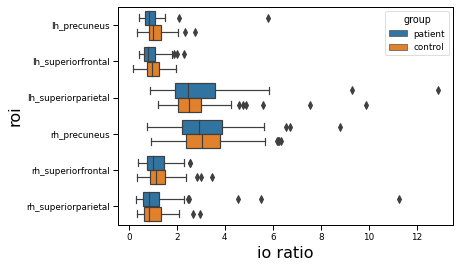

The patient`s variance is greater than the control`s for 5 of 6 rc regions.


In [375]:
## Compare groups in one boxplot with respect to io ratio of rc regions. 
dataframe_patients = pd.DataFrame(io_ratio_rc_patients.reshape(-1),
                                  columns=['io ratio'])
dataframe_patients['group'] = np.repeat('patient', dataframe_patients.size)
dataframe_patients['roi'] = np.matlib.repmat(
    roi_labels[mask_rc], n_patients, 1).reshape(-1)

dataframe_controls = pd.DataFrame(io_ratio_rc_controls.reshape(-1),
                                  columns=['io ratio'])
dataframe_controls['group'] = np.repeat('control', dataframe_controls.size)
dataframe_controls['roi'] = np.matlib.repmat(
    roi_labels[mask_rc], n_controls, 1).reshape(-1)

dataframe_all_subjects = dataframe_patients.append(dataframe_controls)

ax = sns.boxplot(x = dataframe_all_subjects['io ratio'], 
            y = dataframe_all_subjects['roi'], 
            hue = dataframe_all_subjects['group'])
sns.set_context("paper", rc={"font.size":8,"axes.titlesize":8,"axes.labelsize":16})
#ax.set_title("Title",fontsize=24)
plt.show()
roi_count_patients_greater_than_controls = sum(
    np.var(io_ratio_rc_patients, axis=0) > np.var(io_ratio_rc_controls, axis=0))
print('The patient`s variance is greater than the control`s for', 
      roi_count_patients_greater_than_controls, 'of', 
      len(indexes_rc), 'rc regions.')

In [376]:
"""
Patients: Analyse input into rc with regard to max values. 
"""

n_max_values = 5
# Find subjects responsible for the outliers.
print(black('Input: Examine the subjects responsible for the largest value per region:', 'bold'))
input_Counter_subjects_total_patients = Counter()
input_Counter_rois_total_patients = Counter()
output_Counter_subjects_total_patients = Counter()
output_Counter_rois_total_patients = Counter()
for i_max in range(n_max_values):
    print('\t', str(i_max+1) + '. largest value')
    condition = input_patients.T == np.outer(np.sort(
        input_patients, axis=0)[-i_max-1, :], np.ones([n_patients]))
    print(np.asarray(condition).nonzero())
    input_Counter_subjects = Counter(np.asarray(condition).nonzero()[1])
    print(input_Counter_subjects)
    print(sorted(input_Counter_subjects))
    input_Counter_subjects_total_patients += input_Counter_subjects
    #print(sorted(list(unique_everseen(np.asarray(condition).nonzero()[1]))))
# Find rois responsible for the largest values per subject
print(black('RC-indexes:\n', 'bold'), indexes_rc)
print(black('Input: Examine the rois responsible for the largest value per subject:', 'bold'))
for i_max in range(n_max_values):
    print('\t', str(i_max+1) + '. largest value')
    condition = input_patients == np.outer(np.sort(
        input_patients, axis=1)[:, -i_max-1], np.ones([n_rois]))
    print(np.asarray(condition).nonzero())
    input_Counter_rois = Counter(np.asarray(condition).nonzero()[1])
    print(input_Counter_rois)
    print(sorted(input_Counter_rois))
    input_Counter_rois_total_patients += input_Counter_rois
    #print(sorted(list(unique_everseen(np.asarray(condition).nonzero()[1]))))

## Analyse rc output with regard to max values.
# Find subjects responsible for the outliers.
print(black('Output: Examine the subjects responsible for the largest value per region:', 'bold'))
for i_max in range(n_max_values):
    print('\t', str(i_max+1) + '. largest value')
    condition = output_patients.T == np.outer(np.sort(
        output_patients, axis=0)[-i_max-1, :], np.ones([n_patients]))
    print(np.asarray(condition).nonzero())
    output_Counter_subjects = Counter(np.asarray(condition).nonzero()[1])
    print(output_Counter_subjects)
    print(sorted(output_Counter_subjects))
    output_Counter_subjects_total_patients += output_Counter_subjects
    #print(sorted(list(unique_everseen(np.asarray(condition).nonzero()[1]))))
# Find rois responsible for the largest values per subject
print(black('RC-indexes:\n', 'bold'), indexes_rc)
print(black('Output: Examine the rois responsible for the largest value per subject:', 'bold'))
for i_max in range(n_max_values):
    print('\t', str(i_max+1) + '. largest value')
    condition = output_patients == np.outer(np.sort(
        output_patients, axis=1)[:, -i_max-1], np.ones([n_rois]))
    print(np.asarray(condition).nonzero())
    output_Counter_rois = Counter(np.asarray(condition).nonzero()[1])
    print(output_Counter_rois)
    print(sorted(output_Counter_rois))
    output_Counter_rois_total_patients += output_Counter_rois
    #print(sorted(list(unique_everseen(np.asarray(condition).nonzero()[1]))))

## Analyse rc io ratio with regard to max values. 
print(black('Examine the subjects responsible for the largest io ratio:', 'bold'))
for i_max in range(n_max_values):
    print('\t', str(i_max+1) + '. largest value')
    condition = io_ratio_rc_patients.T == np.outer(np.sort(
        io_ratio_rc_patients, axis=0)[-i_max-1, :], np.ones([n_patients]))
    print(np.asarray(condition).nonzero())
    print(Counter(np.asarray(condition).nonzero()[1]))
    print(sorted(Counter(np.asarray(condition).nonzero()[1])))
    

Input: Examine the subjects responsible for the largest value per region:
	 1. largest value
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67],
      dtype=int64), array([12, 21, 58, 46, 41, 37, 41, 46,  5,  3, 23,  5, 50, 21, 21, 12, 11,
       41, 21,  3, 21,  5, 41,  9,  5,  5, 41, 41, 51, 12, 50, 21, 12,  3,
       23, 12, 28, 41, 51, 41, 12, 46, 46, 51, 37,  7, 29, 46, 21, 12, 51,
       51, 41,  5, 12,  5,  5, 12, 35, 41, 46, 41, 41, 21,  0, 46, 12,  5],
      dtype=int64))
Counter({41: 12, 12: 10, 5: 9, 21: 8, 46: 7, 51: 5, 3: 3, 37: 2, 23: 2, 50: 2, 58: 1, 11: 1, 9: 1, 28: 1, 7: 1, 29: 1, 35: 1, 0: 1})
[0, 3, 5, 7, 9, 11, 12, 21, 23, 28, 29, 35, 37, 41, 46, 50, 51, 58]
	 2. largest value
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 

In [377]:
"""
Patients: Analyse input from the periphery into the rc with regard
to max values. 
"""

n_max_values = 5
# Find subjects responsible for the outliers.
print(black('Input: Examine the subjects responsible for the largest value per region:', 'bold'))
input_Counter_subjects_total_controls = Counter()
input_Counter_rois_total_controls = Counter()
output_Counter_subjects_total_controls = Counter()
output_Counter_rois_total_controls = Counter()
for i_max in range(n_max_values):
    print('\t', str(i_max+1) + '. largest value')
    condition = input_controls.T == np.outer(np.sort(
        input_controls, axis=0)[-i_max-1, :], np.ones([n_controls]))
    print(np.asarray(condition).nonzero())
    input_Counter_subjects = Counter(np.asarray(condition).nonzero()[1])
    print(input_Counter_subjects)
    print(sorted(input_Counter_subjects))
    input_Counter_subjects_total_controls += input_Counter_subjects
    #print(sorted(list(unique_everseen(np.asarray(condition).nonzero()[1]))))
# Find rois responsible for the largest values per subject
print(black('RC-indexes:\n', 'bold'), indexes_rc)
print(black('Input: Examine the rois responsible for the largest value per subject:', 'bold'))
for i_max in range(n_max_values):
    print('\t', str(i_max+1) + '. largest value')
    condition = input_controls == np.outer(np.sort(
        input_controls, axis=1)[:, -i_max-1], np.ones([n_rois]))
    print(np.asarray(condition).nonzero())
    input_Counter_rois = Counter(np.asarray(condition).nonzero()[1])
    print(input_Counter_rois)
    print(sorted(input_Counter_rois))
    input_Counter_rois_total_controls += input_Counter_rois
    #print(sorted(list(unique_everseen(np.asarray(condition).nonzero()[1]))))

## Analyse rc output with regard to max values.
# Find subjects responsible for the outliers.
print(black('Output: Examine the subjects responsible for the largest value per region:', 'bold'))
for i_max in range(n_max_values):
    print('\t', str(i_max+1) + '. largest value')
    condition = output_controls.T == np.outer(np.sort(
        output_controls, axis=0)[-i_max-1, :], np.ones([n_controls]))
    print(np.asarray(condition).nonzero())
    output_Counter_subjects = Counter(np.asarray(condition).nonzero()[1])
    print(output_Counter_subjects)
    print(sorted(output_Counter_subjects))
    output_Counter_subjects_total_controls += output_Counter_subjects
    #print(sorted(list(unique_everseen(np.asarray(condition).nonzero()[1]))))
# Find rois responsible for the largest values per subject
print(black('RC-indexes:\n', 'bold'), indexes_rc)
print(black('Output: Examine the rois responsible for the largest value per subject:', 'bold'))
for i_max in range(n_max_values):
    print('\t', str(i_max+1) + '. largest value')
    condition = output_controls == np.outer(np.sort(
        output_controls, axis=1)[:, -i_max-1], np.ones([n_rois]))
    print(np.asarray(condition).nonzero())
    output_Counter_rois = Counter(np.asarray(condition).nonzero()[1])
    print(output_Counter_rois)
    print(sorted(output_Counter_rois))
    output_Counter_rois_total_controls += output_Counter_rois
    #print(sorted(list(unique_everseen(np.asarray(condition).nonzero()[1]))))

## Analyse rc io ratio with regard to max values. 
print(black('Examine the subjects responsible for the largest io ratio:', 'bold'))
for i_max in range(n_max_values):
    print('\t', str(i_max+1) + '. largest value')
    condition = io_ratio_rc_controls.T == np.outer(np.sort(
        io_ratio_rc_controls, axis=0)[-i_max-1, :], np.ones([n_controls]))
    print(np.asarray(condition).nonzero())
    print(Counter(np.asarray(condition).nonzero()[1]))
    print(sorted(Counter(np.asarray(condition).nonzero()[1])))

Input: Examine the subjects responsible for the largest value per region:
	 1. largest value
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67],
      dtype=int64), array([48, 48,  8, 64, 46, 57,  8, 46, 38, 46, 46, 57,  5, 46,  8,  8,  8,
       64, 19, 38, 57, 33,  8, 57,  8,  4, 64,  7, 57, 46, 64, 64,  8, 57,
       46, 57, 57,  5,  7, 46,  5, 48, 64,  8, 57,  8,  5, 46,  5, 33, 57,
       46, 46,  5, 46, 21, 46,  8,  8, 64, 57, 57, 57, 47,  8,  7,  5, 46],
      dtype=int64))
Counter({46: 14, 8: 13, 57: 13, 64: 7, 5: 7, 48: 3, 7: 3, 38: 2, 33: 2, 19: 1, 4: 1, 21: 1, 47: 1})
[4, 5, 7, 8, 19, 21, 33, 38, 46, 47, 48, 57, 64]
	 2. largest value
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 2

Counter({64: 9, 46: 9, 19: 8, 48: 7, 57: 5, 8: 4, 51: 3, 67: 2, 18: 2, 33: 2, 21: 2, 5: 2, 24: 2, 63: 2, 41: 1, 49: 1, 44: 1, 12: 1, 47: 1, 52: 1, 54: 1, 43: 1, 31: 1})
[5, 8, 12, 18, 19, 21, 24, 31, 33, 41, 43, 44, 46, 47, 48, 49, 51, 52, 54, 57, 63, 64, 67]
	 4. largest value
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67],
      dtype=int64), array([67, 37, 24,  8, 61, 39, 11,  8, 37, 67, 46, 38, 47, 64, 57, 57, 46,
       57,  8, 46, 33,  7, 19,  5, 64, 57, 48, 64,  8, 64, 46, 48,  7, 46,
       37, 61, 48,  5, 46, 36,  4, 46, 21, 48, 31, 19, 38, 18, 33, 67, 20,
       57, 57, 57,  7,  7, 42,  8, 19, 64,  8, 67, 57,  4,  4, 51, 48, 46],
      dtype=int64))
Counter({46: 8, 57: 8, 8: 6, 64: 5, 48: 5, 67: 4, 7: 4, 37: 3, 19: 3, 4: 3, 61

In [378]:
## Compare patients and controls with respect to the maximum io values (feeder).
print(indexes_rc)
print(black('Patients:', 'bold'))
print('\ninput_Counter_subjects_total_patients:', input_Counter_subjects_total_patients)
print('output_Counter_subjects_total_patients:', output_Counter_subjects_total_patients)
print('\ninput_Counter_rois_total_patients:', input_Counter_rois_total_patients)
print('output_Counter_rois_total_patients:', output_Counter_rois_total_patients)
print(black('Controls:', 'bold'))
print('\ninput_Counter_subjects_total_controls:', input_Counter_subjects_total_controls)
print('output_Counter_subjects_total_controls:', output_Counter_subjects_total_controls)
print('\ninput_Counter_rois_total_controls:', input_Counter_rois_total_controls)
print('output_Counter_rois_total_controls:', output_Counter_rois_total_controls)

[23 57 26 60 27 61]
Patients:

input_Counter_subjects_total_patients: Counter({41: 38, 5: 34, 12: 29, 46: 26, 3: 23, 58: 21, 51: 21, 21: 19, 23: 15, 50: 12, 29: 12, 37: 10, 11: 9, 7: 8, 9: 7, 35: 6, 10: 6, 0: 5, 17: 5, 54: 5, 56: 5, 30: 4, 28: 3, 6: 3, 31: 3, 20: 3, 36: 2, 44: 1, 24: 1, 27: 1, 55: 1, 15: 1, 2: 1})
output_Counter_subjects_total_patients: Counter({46: 35, 41: 34, 12: 25, 5: 23, 21: 20, 3: 20, 51: 20, 58: 18, 23: 17, 29: 15, 35: 10, 37: 10, 9: 8, 7: 8, 6: 8, 50: 7, 11: 7, 28: 6, 10: 5, 15: 5, 0: 4, 56: 4, 54: 4, 44: 4, 20: 3, 30: 3, 17: 3, 36: 3, 8: 2, 31: 2, 26: 2, 55: 1, 34: 1, 40: 1, 24: 1, 27: 1})

input_Counter_rois_total_patients: Counter({26: 49, 60: 47, 56: 20, 28: 20, 67: 19, 45: 17, 62: 16, 57: 12, 61: 12, 22: 11, 11: 10, 3: 10, 23: 7, 33: 6, 9: 5, 27: 4, 37: 4, 10: 4, 43: 3, 24: 3, 8: 2, 44: 2, 13: 2, 7: 2, 12: 2, 54: 2, 55: 2, 63: 1, 53: 1, 25: 1, 19: 1, 39: 1, 46: 1, 20: 1})
output_Counter_rois_total_patients: Counter({8: 34, 57: 31, 23: 25, 42: 25, 61: 20, 5

In [379]:
## Test feeder io ratio for normal distribution
def test_for_normal_dist(array_2D, significance_level_ind):
    n_subjects = np.fmin(n_patients, n_controls)
    array_2D = array_2D[:n_subjects]
    significance_level = stt.anderson(
        np.ones(2)).significance_level[significance_level_ind]
    anderson_results = np.array([stt.anderson(dist).statistic
                        > stt.anderson(dist).critical_values[significance_level_ind]
                                 for dist in array_2D.T], dtype=bool)
    print('\t', np.array(np.where(anderson_results)).shape[1], 'of', 
          array_2D.shape[1], str('regions significantly ('
                                 + str(int(significance_level)) + '%)'), 
          'differ from a normal distribution.')
    #[(plt.figure(), plt.hist(dist, bins=np.linspace(
    #    array_2D.min(), array_2D.max(), 100))) for dist in array_2D.T ]
    #plt.show()
## Test each subject's data as a whole on normal distribution
#anderson2 = np.array([(stt.anderson(x).statistic > stt.anderson(x).critical_values[2]) for x in ts_patients.reshape(n_patients, -1)], dtype=bool)
#print(anderson2.shape)
#np.array(np.where(anderson2)).shape
significance_level_ind = 2
print(black('\nPatient group:', 'bold'))
test_for_normal_dist(io_ratio_rc_patients, significance_level_ind)
print(black('\nControl group:', 'bold'))
test_for_normal_dist(io_ratio_rc_controls, significance_level_ind)


Patient group:
	 6 of 6 regions significantly (5%) differ from a normal distribution.

Control group:
	 5 of 6 regions significantly (5%) differ from a normal distribution.


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1786: RuntimeWarning: invalid value encountered in true_divide
  w = (y - xbar) / s


In [380]:
## Test feeder io ratio for normal distribution
def test_for_specific_dist(array_2D, dist_type, significance_level_ind):
    n_subjects = np.fmin(n_patients, n_controls)
    array_2D = array_2D[:n_subjects]
    significance_level = stt.anderson(
        np.ones(2)).significance_level[significance_level_ind]
    anderson_results = np.array(
        [stt.anderson(array_1D, dist=dist_type).statistic
         > stt.anderson(array_1D, dist=dist_type).critical_values[
             significance_level_ind] for array_1D in array_2D.T], dtype=bool)
    print('\t', np.array(np.where(anderson_results)).shape[1], 'of', 
          array_2D.shape[1], str('regions significantly ('
                                 + str(int(significance_level)) + '%)'), 
          'differ from a', dist_type, 'distribution.')
    #[(plt.figure(), plt.hist(dist, bins=np.linspace(
    #    array_2D.min(), array_2D.max(), 100))) for dist in array_2D.T ]
    #plt.show()

significance_level_ind = 2
print(black('\nPatient group:', 'bold'))
test_for_specific_dist(input_patients, 'logistic', significance_level_ind)
print(black('\nControl group:', 'bold'))
test_for_specific_dist(input_controls, 'logistic', significance_level_ind)

print(black('\nPatient group:', 'bold'))
test_for_specific_dist(input_patients, 'norm', significance_level_ind)
print(black('\nControl group:', 'bold'))
test_for_specific_dist(input_controls, 'norm', significance_level_ind)

print(black('\nPatient group:', 'bold'))
test_for_specific_dist(input_patients, 'gumbel', significance_level_ind)
print(black('\nControl group:', 'bold'))
test_for_specific_dist(input_controls, 'gumbel', significance_level_ind)

print(black('\nPatient group:', 'bold'))
test_for_specific_dist(input_patients, 'expon', significance_level_ind)
print(black('\nControl group:', 'bold'))
test_for_specific_dist(input_controls, 'expon', significance_level_ind)


Patient group:


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1801: RuntimeWarning: overflow encountered in exp
  tmp2 = exp(tmp)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1803: RuntimeWarning: invalid value encountered in true_divide
  np.sum(tmp*(1.0-tmp2)/(1+tmp2), axis=0) + N]
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


	 36 of 68 regions significantly (5%) differ from a logistic distribution.

Control group:
	 65 of 68 regions significantly (5%) differ from a logistic distribution.

Patient group:
	 44 of 68 regions significantly (5%) differ from a norm distribution.

Control group:
	 67 of 68 regions significantly (5%) differ from a norm distribution.

Patient group:
	 68 of 68 regions significantly (5%) differ from a gumbel distribution.

Control group:
	 68 of 68 regions significantly (5%) differ from a gumbel distribution.

Patient group:
	 68 of 68 regions significantly (5%) differ from a expon distribution.

Control group:
	 64 of 68 regions significantly (5%) differ from a expon distribution.


In [381]:
## Test inputs for normal distribution.
significance_level_ind = 2
input_rc_patients = input_patients[:, mask_rc]
input_rc_controls = input_controls[:, mask_rc]
print(black('\nExamine all rois:', 'bold'))
print(black('\n\tPatient group:', 'bold'))
test_for_normal_dist(input_patients, significance_level_ind)
print(black('\n\tControl group:', 'bold'))
test_for_normal_dist(input_controls, significance_level_ind)
print(black('\nExamine rc:', 'bold'))
print(black('\n\tPatient group:', 'bold'))
test_for_normal_dist(input_rc_patients, significance_level_ind)
print(black('\n\tControl group:', 'bold'))
test_for_normal_dist(input_rc_controls, significance_level_ind)


Examine all rois:

	Patient group:
	 44 of 68 regions significantly (5%) differ from a normal distribution.

	Control group:
	 67 of 68 regions significantly (5%) differ from a normal distribution.

Examine rc:

	Patient group:
	 3 of 6 regions significantly (5%) differ from a normal distribution.

	Control group:
	 6 of 6 regions significantly (5%) differ from a normal distribution.


In [382]:
## Test inputs without extrem values for normal distribution.
significance_level_ind = 2 # corresponding to 5%
n_subjects = np.fmin(n_patients, n_controls)
input_rc_cut_patients = np.sort(input_patients[:n_subjects, mask_rc], axis=0)[:-3, :]
input_rc_cut_controls = np.sort(input_controls[:n_subjects, mask_rc], axis=0)[:-3, :]
print(black('\nPatient group:', 'bold'))
test_for_normal_dist(input_rc_cut_patients, significance_level_ind)
print(black('\nControl group:', 'bold'))
test_for_normal_dist(input_rc_cut_controls, significance_level_ind)


Patient group:
	 3 of 6 regions significantly (5%) differ from a normal distribution.

Control group:
	 5 of 6 regions significantly (5%) differ from a normal distribution.


In [383]:
## Test inputs without extrem values for normal distribution.
significance_level_ind = 2
n_subjects = np.fmin(n_patients, n_controls)
input_rc_cut_patients = np.sort(input_patients[:n_subjects, :], axis=0)[:, :]
input_rc_cut_controls = np.sort(input_controls[:n_subjects, :], axis=0)[:, :]
print(black('\nPatient group:', 'bold'))
test_for_normal_dist(input_rc_cut_patients, significance_level_ind)
print(black('\nControl group:', 'bold'))
test_for_normal_dist(input_rc_cut_controls, significance_level_ind)


Patient group:
	 44 of 68 regions significantly (5%) differ from a normal distribution.

Control group:
	 67 of 68 regions significantly (5%) differ from a normal distribution.


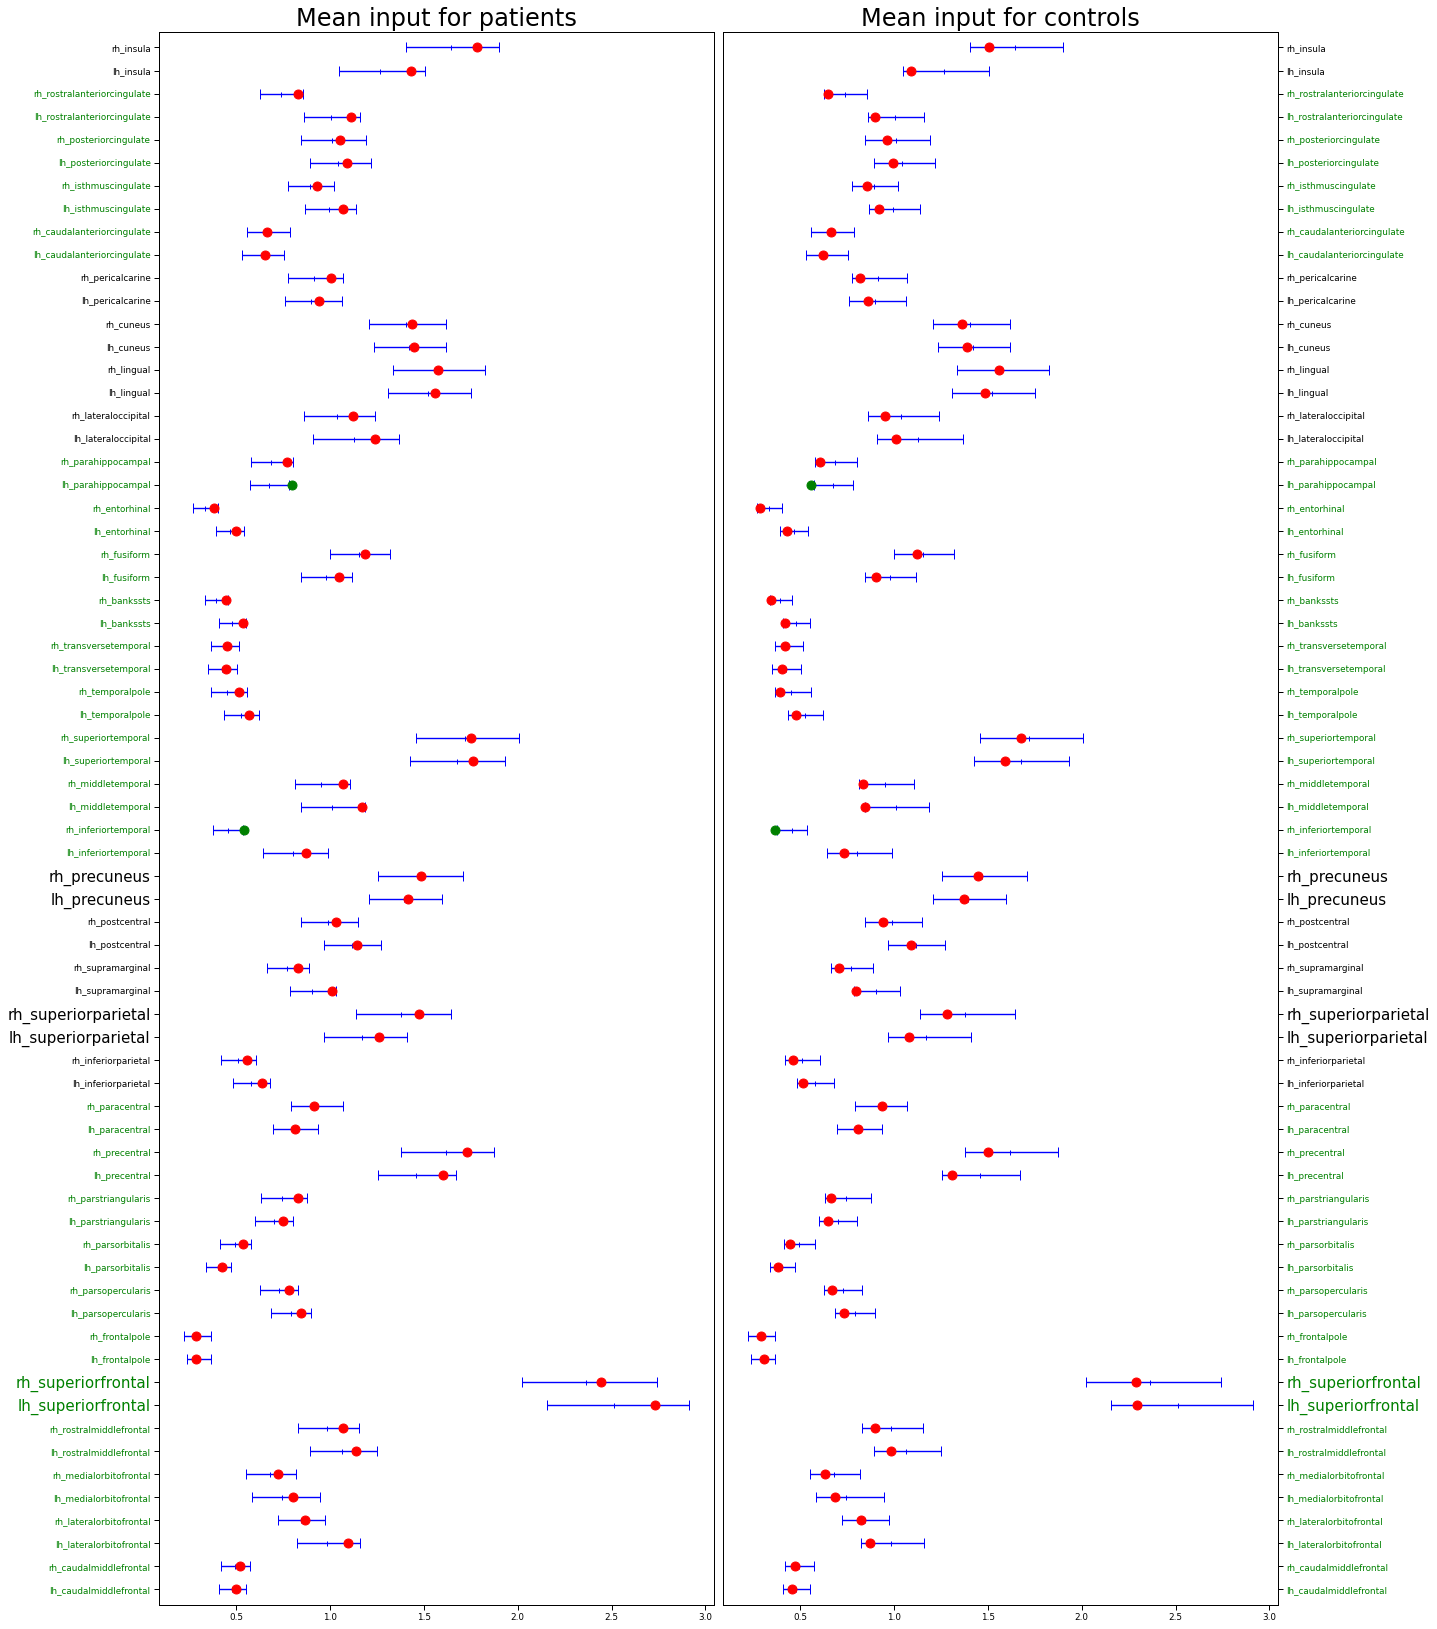

Patients: The parameter value lies above the mean of the values the parameter takes for the permuted groups for
	 64 of 68 rois.
Controls: The parameter value lies above the mean of the values the parameter takes for the permuted groups for
	 3 of 68 rois.
Patients: lh values are greater than rh values for 21 of 34 rois.
Controls: lh values are greater than rh values for 20 of 34 rois.
The mean of the patient's values are smaller than the control's for 4 rois.
For the frontal lobe it is smaller for 2 of 22 rois.
For the temporal lobe it is smaller for 0 of 18 rois.
For the parietal lobe it is smaller for 1 of 10 rois.
For the occipital lobe it is smaller for 0 of 8 rois.
For the cingulate lobe it is smaller for 1 of 8 rois.


In [384]:
#sample_groupsize = 'matched'#'all subjects'
alpha = 0.95
statistic_description = 'Mean input'
y_labels = roi_labels
if sample_groupsize== 'matched':
    n_subjects = np.fmin(n_patients, n_controls)
    fig = examine_significance(input_patients[:n_subjects],
                              input_controls[:n_subjects],
                              input_patients[:n_subjects].mean(axis=0),
                              input_controls[:n_subjects].mean(axis=0),
                              statistic_description, y_labels,
                               roi_indexes_categorized, alpha, np.mean)
else:
    fig = examine_significance(input_patients, input_controls,
                              input_patients.mean(axis=0),
                              input_controls.mean(axis=0),
                              statistic_description, y_labels,
                               roi_indexes_categorized, alpha, np.mean)
if save_figures_flag:
    fig.savefig(str(_FIGURES_DIR + '/mean_all_rois_input.png'), bbox_inches='tight')

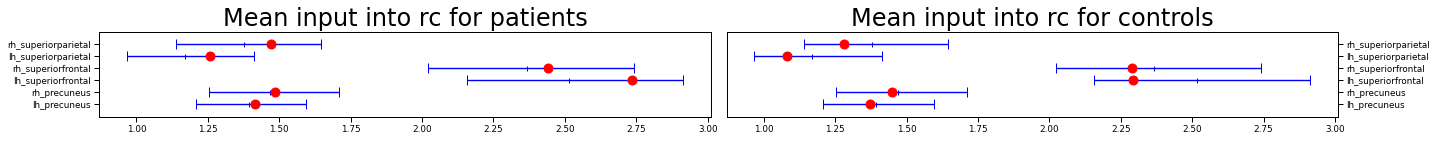

Patients: The parameter value lies above the mean of the values the parameter takes for the permuted groups for
	 6 of 6 rois.
Controls: The parameter value lies above the mean of the values the parameter takes for the permuted groups for
	 0 of 6 rois.
Patients: lh values are greater than rh values for 1 of 3 rois.
Controls: lh values are greater than rh values for 1 of 3 rois.
The mean of the patient's values are smaller than the control's for 0 rois.
For the frontal lobe it is smaller for 0 of 22 rois.
For the temporal lobe it is smaller for 0 of 18 rois.
For the parietal lobe it is smaller for 0 of 10 rois.
For the occipital lobe it is smaller for 0 of 8 rois.
For the cingulate lobe it is smaller for 0 of 8 rois.


In [385]:
## Examine significance of mean of rc input (feeder)
#sample_groupsize = 'matched'#'all subjects'
alpha = 0.95
statistic_description = 'Mean input into rc'
y_labels = roi_labels
if sample_groupsize== 'matched':
    n_subjects = np.fmin(n_patients, n_controls)
    examine_significance(input_patients[:n_subjects],
                              input_controls[:n_subjects],
                              input_patients[:n_subjects].mean(axis=0),
                              input_controls[:n_subjects].mean(axis=0),
                              statistic_description, y_labels, indexes_rc, alpha, np.mean)
else:
    examine_significance(input_patients, input_controls,
                              input_patients.mean(axis=0),
                              input_controls.mean(axis=0),
                              statistic_description, y_labels, indexes_rc, alpha, np.mean)

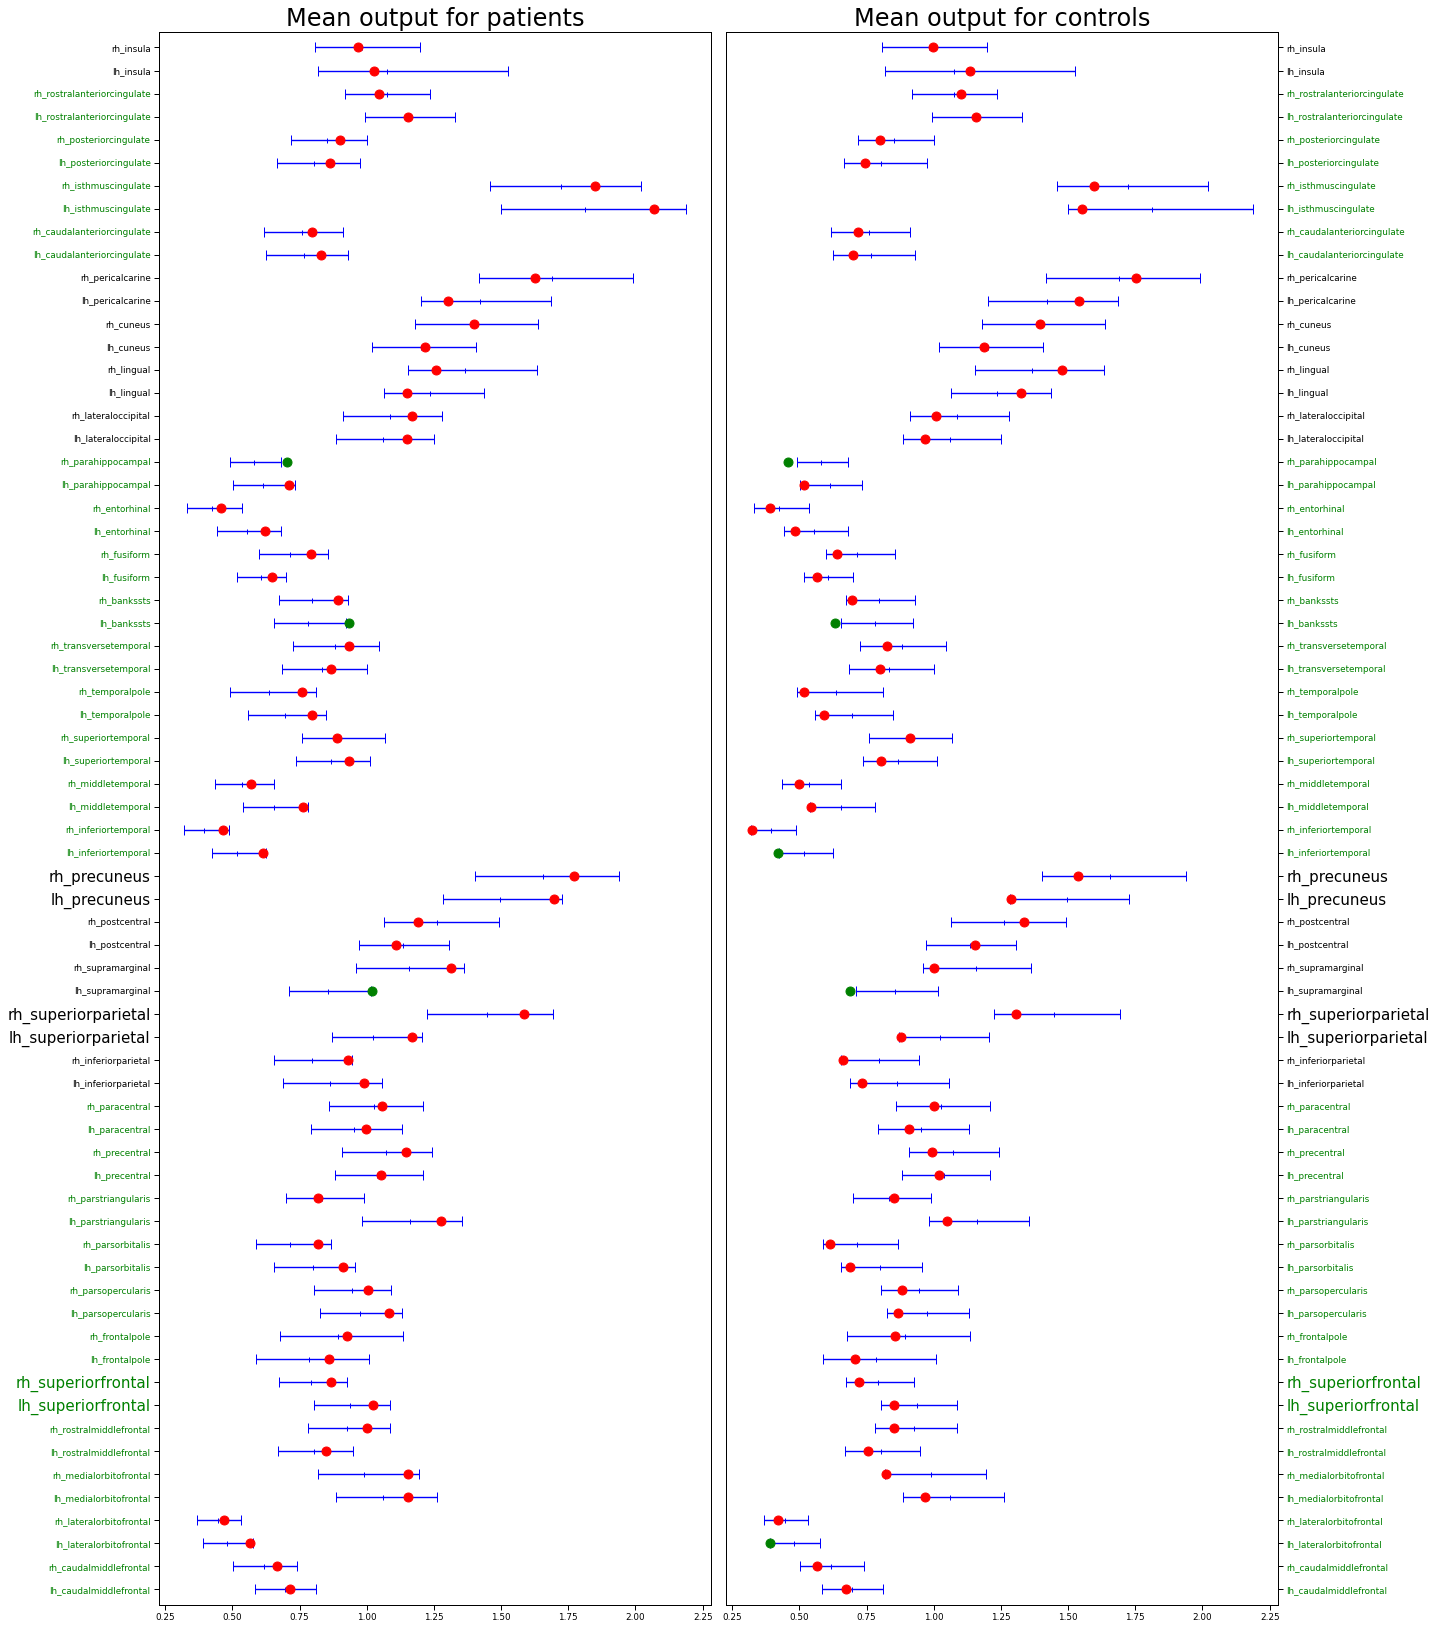

Patients: The parameter value lies above the mean of the values the parameter takes for the permuted groups for
	 56 of 68 rois.
Controls: The parameter value lies above the mean of the values the parameter takes for the permuted groups for
	 12 of 68 rois.
Patients: lh values are greater than rh values for 18 of 34 rois.
Controls: lh values are greater than rh values for 14 of 34 rois.
The mean of the patient's values are smaller than the control's for 12 rois.
For the frontal lobe it is smaller for 1 of 22 rois.
For the temporal lobe it is smaller for 1 of 18 rois.
For the parietal lobe it is smaller for 2 of 10 rois.
For the occipital lobe it is smaller for 3 of 8 rois.
For the cingulate lobe it is smaller for 2 of 8 rois.


In [410]:
#sample_groupsize = 'matched'#'all subjects'
alpha = 0.95
statistic_description = 'Mean output'
y_labels = roi_labels
if sample_groupsize== 'matched':
    n_subjects = np.fmin(n_patients, n_controls)
    fig = examine_significance(output_patients[:n_subjects],
                              output_controls[:n_subjects],
                              output_patients[:n_subjects].mean(axis=0),
                              output_controls[:n_subjects].mean(axis=0),
                              statistic_description, y_labels,
                               roi_indexes_categorized, alpha, np.mean)
else:
    fig = examine_significance(output_patients, output_controls,
                              output_patients.mean(axis=0),
                              output_controls.mean(axis=0),
                              statistic_description, y_labels,
                               roi_indexes_categorized, alpha, np.mean)
fig.savefig(str(_FIGURES_DIR + '/mean_all_rois_output.png'), bbox_inches='tight')

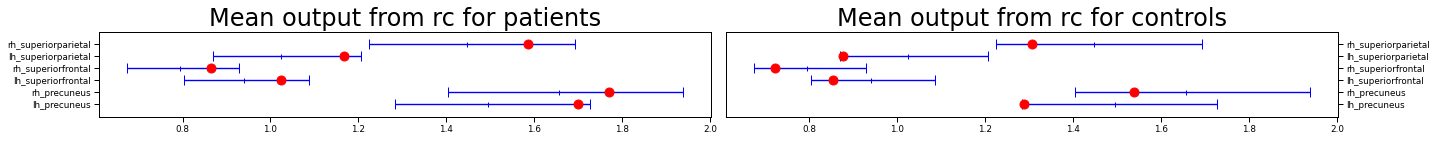

Patients: The parameter value lies above the mean of the values the parameter takes for the permuted groups for
	 6 of 6 rois.
Controls: The parameter value lies above the mean of the values the parameter takes for the permuted groups for
	 0 of 6 rois.
Patients: lh values are greater than rh values for 1 of 3 rois.
Controls: lh values are greater than rh values for 1 of 3 rois.
The mean of the patient's values are smaller than the control's for 0 rois.
For the frontal lobe it is smaller for 0 of 22 rois.
For the temporal lobe it is smaller for 0 of 18 rois.
For the parietal lobe it is smaller for 0 of 10 rois.
For the occipital lobe it is smaller for 0 of 8 rois.
For the cingulate lobe it is smaller for 0 of 8 rois.


In [387]:
## Examine significance of mean of rc output (feeder)
#sample_groupsize = 'matched'#'all subjects'
alpha = 0.95
statistic_description = 'Mean output from rc'
y_labels = roi_labels
if sample_groupsize== 'matched':
    n_subjects = np.fmin(n_patients, n_controls)
    examine_significance(output_patients[:n_subjects],
                              output_controls[:n_subjects],
                              output_patients[:n_subjects].mean(axis=0),
                              output_controls[:n_subjects].mean(axis=0),
                              statistic_description, y_labels, indexes_rc, alpha, np.mean)
else:
    examine_significance(output_patients, output_controls,
                              output_patients.mean(axis=0),
                              output_controls.mean(axis=0),
                              statistic_description, y_labels, indexes_rc, alpha, np.mean)

<ipython-input-388-29f9e608abd3>:6: RuntimeWarning: divide by zero encountered in true_divide
  io_ratio_patients = input_patients/output_patients
<ipython-input-388-29f9e608abd3>:6: RuntimeWarning: invalid value encountered in true_divide
  io_ratio_patients = input_patients/output_patients


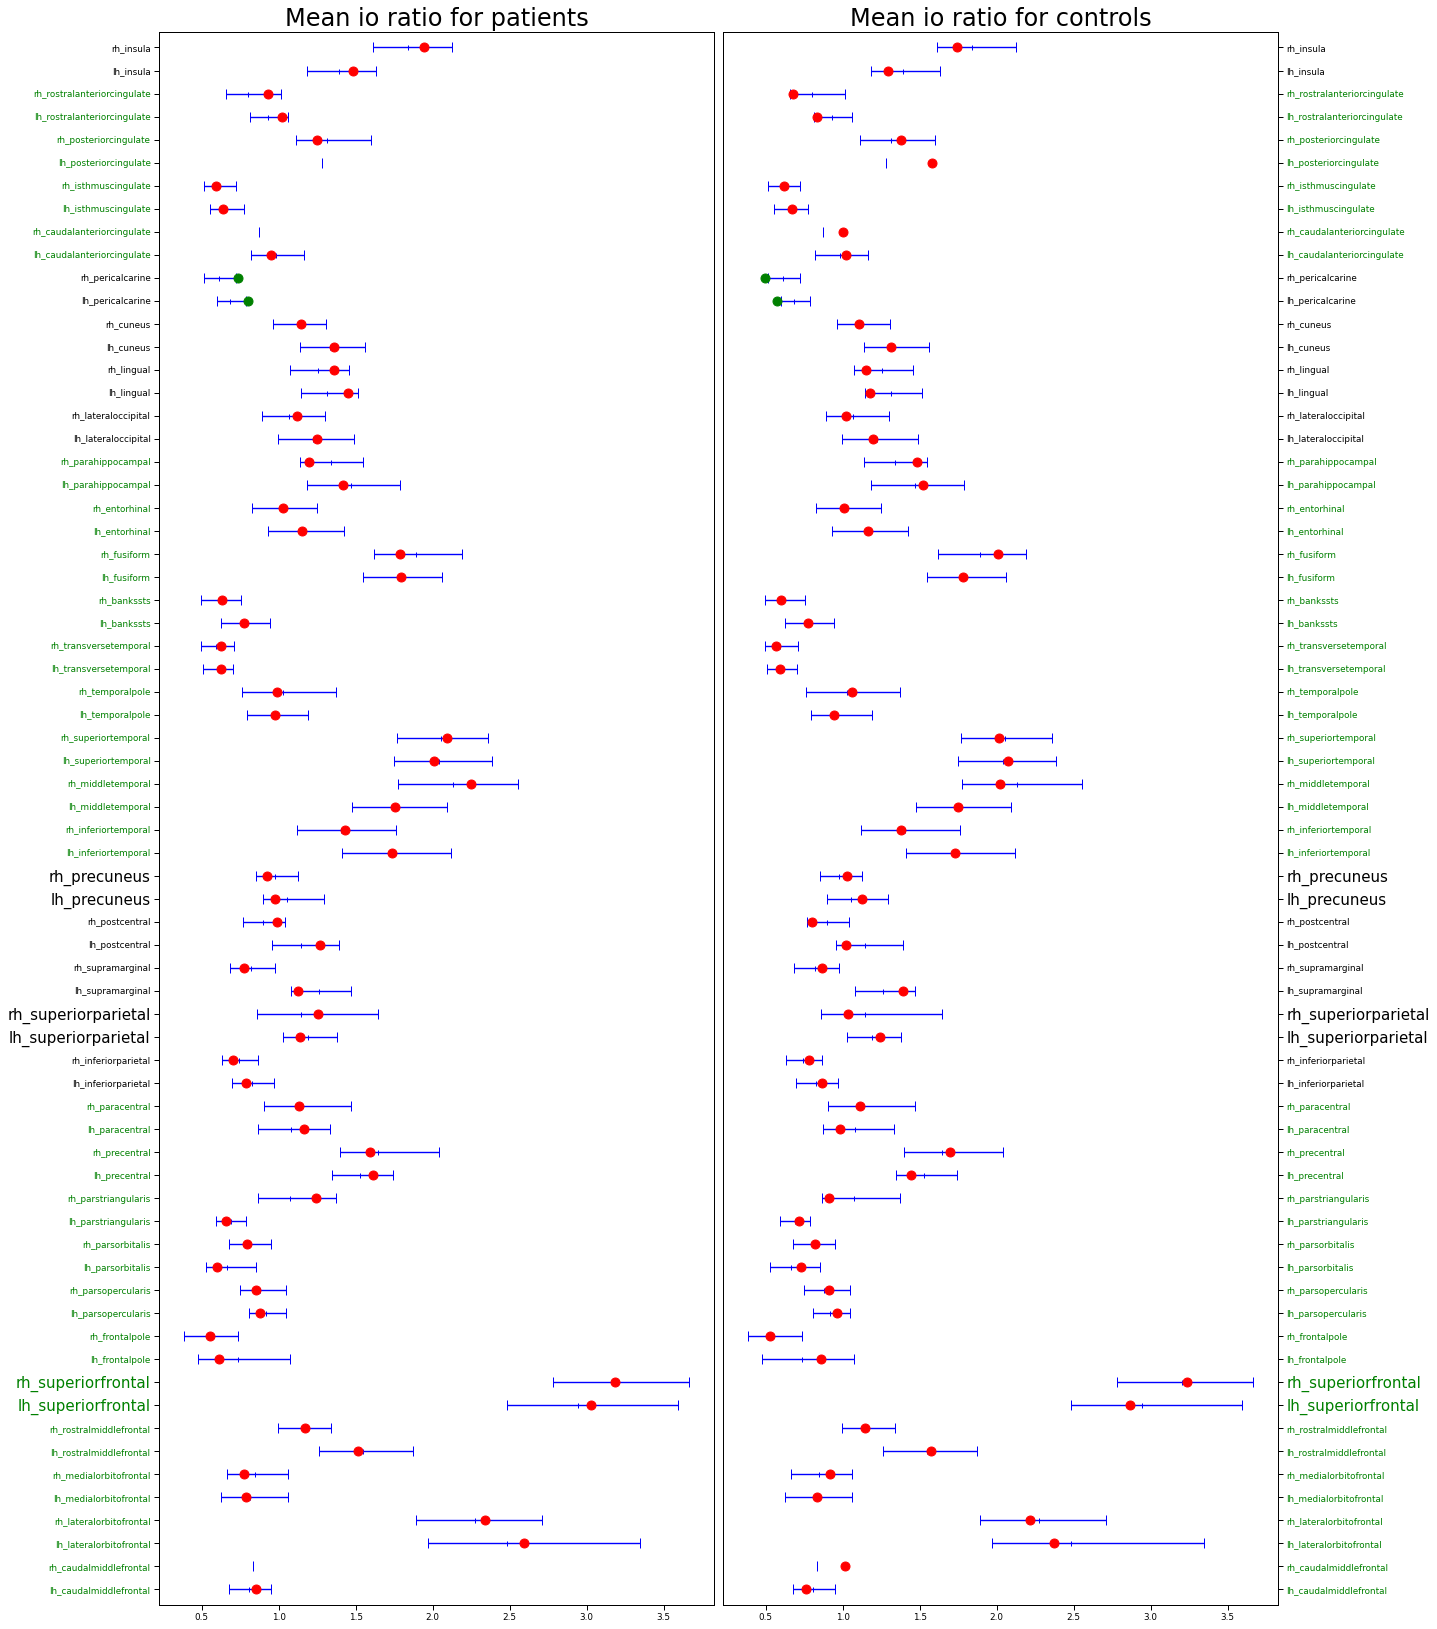

Patients: The parameter value lies above the mean of the values the parameter takes for the permuted groups for
	 36 of 68 rois.
Controls: The parameter value lies above the mean of the values the parameter takes for the permuted groups for
	 28 of 68 rois.
Patients: lh values are greater than rh values for 23 of 34 rois.
Controls: lh values are greater than rh values for 23 of 34 rois.
The mean of the patient's values are smaller than the control's for 28 rois.
For the frontal lobe it is smaller for 11 of 22 rois.
For the temporal lobe it is smaller for 6 of 18 rois.
For the parietal lobe it is smaller for 6 of 10 rois.
For the occipital lobe it is smaller for 1 of 8 rois.
For the cingulate lobe it is smaller for 4 of 8 rois.


In [388]:
## Examine significance of mean of io ratio (feeder)
#sample_groupsize = 'matched'#'all subjects'
alpha = 0.99
statistic_description = 'Mean io ratio'
y_labels = roi_labels
io_ratio_patients = input_patients/output_patients
io_ratio_controls = input_controls/output_controls
sample_groupsize = 'matched'
if sample_groupsize== 'matched':
    n_subjects = np.fmin(n_patients, n_controls)
    fig = examine_significance(io_ratio_patients,
                              io_ratio_controls,
                              io_ratio_patients[:n_subjects].mean(axis=0),
                              io_ratio_controls[:n_subjects].mean(axis=0),
                              statistic_description, y_labels, roi_indexes_categorized, alpha, np.mean)
else:
    fig = examine_significance(io_ratio_patients, io_ratio_controls,
                              io_ratio_patients.mean(axis=0),
                              io_ratio_controls.mean(axis=0),
                              statistic_description, y_labels, roi_indexes_categorized, alpha, np.mean)
#fig.savefig(str(_FIGURES_DIR + '/mean_all_rois_io_ratio_95.png'), bbox_inches='tight')

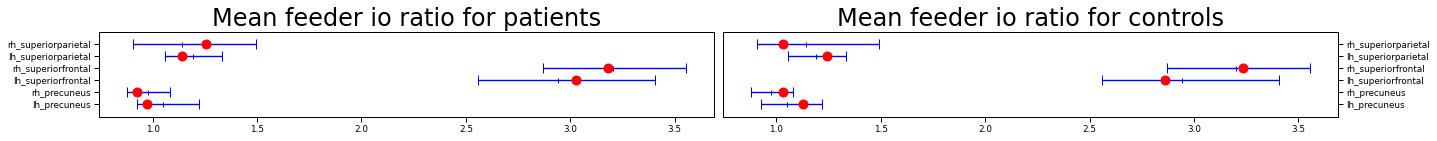

Patients: The parameter value lies above the mean of the values the parameter takes for the permuted groups for
	 2 of 6 rois.
Controls: The parameter value lies above the mean of the values the parameter takes for the permuted groups for
	 4 of 6 rois.
Patients: lh values are greater than rh values for 1 of 3 rois.
Controls: lh values are greater than rh values for 2 of 3 rois.
The mean of the patient's values are smaller than the control's for 4 rois.
For the frontal lobe it is smaller for 4 of 22 rois.
For the temporal lobe it is smaller for 0 of 18 rois.
For the parietal lobe it is smaller for 0 of 10 rois.
For the occipital lobe it is smaller for 0 of 8 rois.
For the cingulate lobe it is smaller for 0 of 8 rois.


In [389]:
## Examine significance of mean of io ratio (feeder)
#sample_groupsize = 'matched'#'all subjects'
alpha = 0.95
statistic_description = 'Mean feeder io ratio'
y_labels = roi_labels
if sample_groupsize== 'matched':
    n_subjects = np.fmin(n_patients, n_controls)
    examine_significance(io_ratio_patients,
                              io_ratio_controls,
                              io_ratio_patients[:n_subjects].mean(axis=0),
                              io_ratio_controls[:n_subjects].mean(axis=0),
                              statistic_description, y_labels, indexes_rc, alpha, np.mean)
else:
    examine_significance(io_ratio_patients, io_ratio_controls,
                              io_ratio_patients.mean(axis=0),
                              io_ratio_controls.mean(axis=0),
                              statistic_description, y_labels, indexes_rc, alpha, np.mean)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


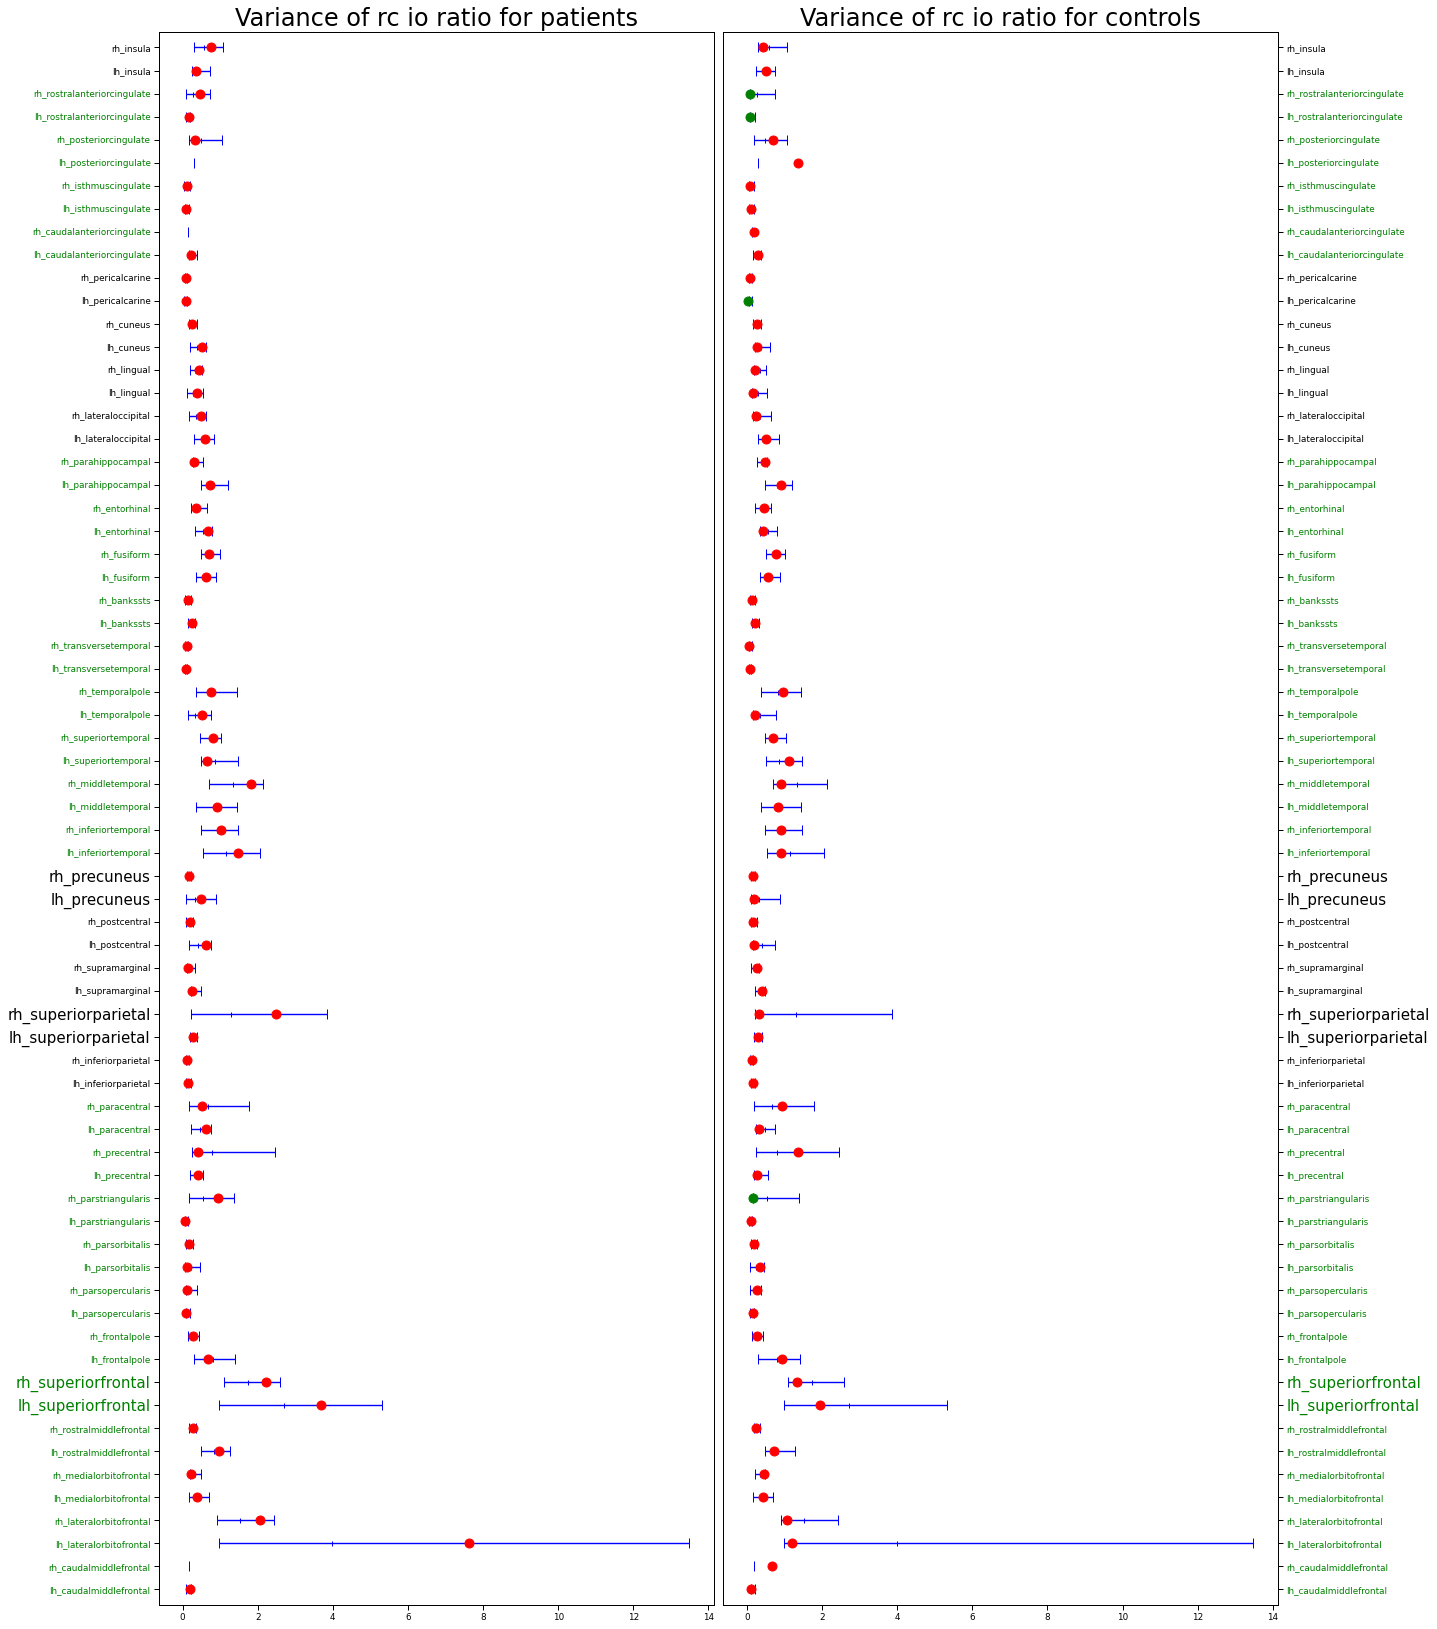

Patients: The parameter value lies above the mean of the values the parameter takes for the permuted groups for
	 40 of 68 rois.
Controls: The parameter value lies above the mean of the values the parameter takes for the permuted groups for
	 26 of 68 rois.
Patients: lh values are greater than rh values for 18 of 34 rois.
Controls: lh values are greater than rh values for 21 of 34 rois.
The mean of the patient's values are smaller than the control's for 25 rois.
For the frontal lobe it is smaller for 9 of 22 rois.
For the temporal lobe it is smaller for 5 of 18 rois.
For the parietal lobe it is smaller for 5 of 10 rois.
For the occipital lobe it is smaller for 2 of 8 rois.
For the cingulate lobe it is smaller for 3 of 8 rois.


In [390]:
## Examine significance of variance of rc io ratio (feeder)
#sample_groupsize = 'matched'#'all subjects'
alpha = 0.90
statistic_description = 'Variance of rc io ratio'
y_labels = roi_labels
if sample_groupsize== 'matched':
    n_subjects = np.fmin(n_patients, n_controls)
    examine_significance(io_ratio_patients, io_ratio_controls,
                         np.var(io_ratio_patients[:n_subjects], axis=0),
                         np.var(io_ratio_controls[:n_subjects], axis=0),
                         statistic_description, y_labels, roi_indexes_categorized, alpha, np.var)
else:
    examine_significance(io_ratio_patients, io_ratio_controls,
                         np.var(io_ratio_patients, axis=0),
                         np.var(io_ratio_controls, axis=0),
                         statistic_description, y_labels, roi_indexes_categorized, alpha, np.var)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


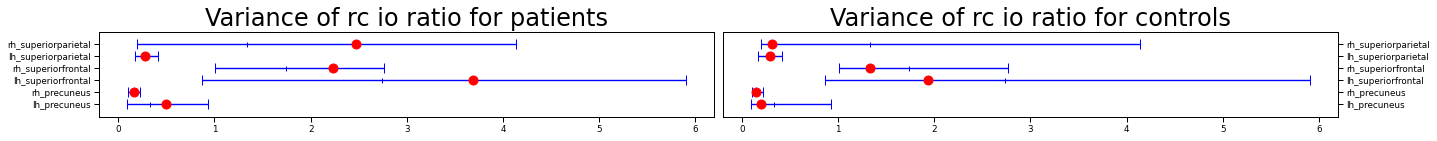

Patients: The parameter value lies above the mean of the values the parameter takes for the permuted groups for
	 5 of 6 rois.
Controls: The parameter value lies above the mean of the values the parameter takes for the permuted groups for
	 1 of 6 rois.
Patients: lh values are greater than rh values for 2 of 3 rois.
Controls: lh values are greater than rh values for 2 of 3 rois.
The mean of the patient's values are smaller than the control's for 1 rois.
For the frontal lobe it is smaller for 1 of 22 rois.
For the temporal lobe it is smaller for 0 of 18 rois.
For the parietal lobe it is smaller for 0 of 10 rois.
For the occipital lobe it is smaller for 0 of 8 rois.
For the cingulate lobe it is smaller for 0 of 8 rois.


In [391]:
## Examine significance of variance of rc io ratio (feeder)
#sample_groupsize = 'matched'#'all subjects'
alpha = 0.95
statistic_description = 'Variance of rc io ratio'
y_labels = roi_labels
if sample_groupsize== 'matched':
    n_subjects = np.fmin(n_patients, n_controls)
    examine_significance(io_ratio_patients, io_ratio_controls,
                         np.var(io_ratio_patients[:n_subjects], axis=0),
                         np.var(io_ratio_controls[:n_subjects], axis=0),
                         statistic_description, y_labels, indexes_rc, alpha, np.var)
else:
    examine_significance(io_ratio_patients, io_ratio_controls,
                         np.var(io_ratio_patients, axis=0),
                         np.var(io_ratio_controls, axis=0),
                         statistic_description, y_labels, indexes_rc, alpha, np.var)

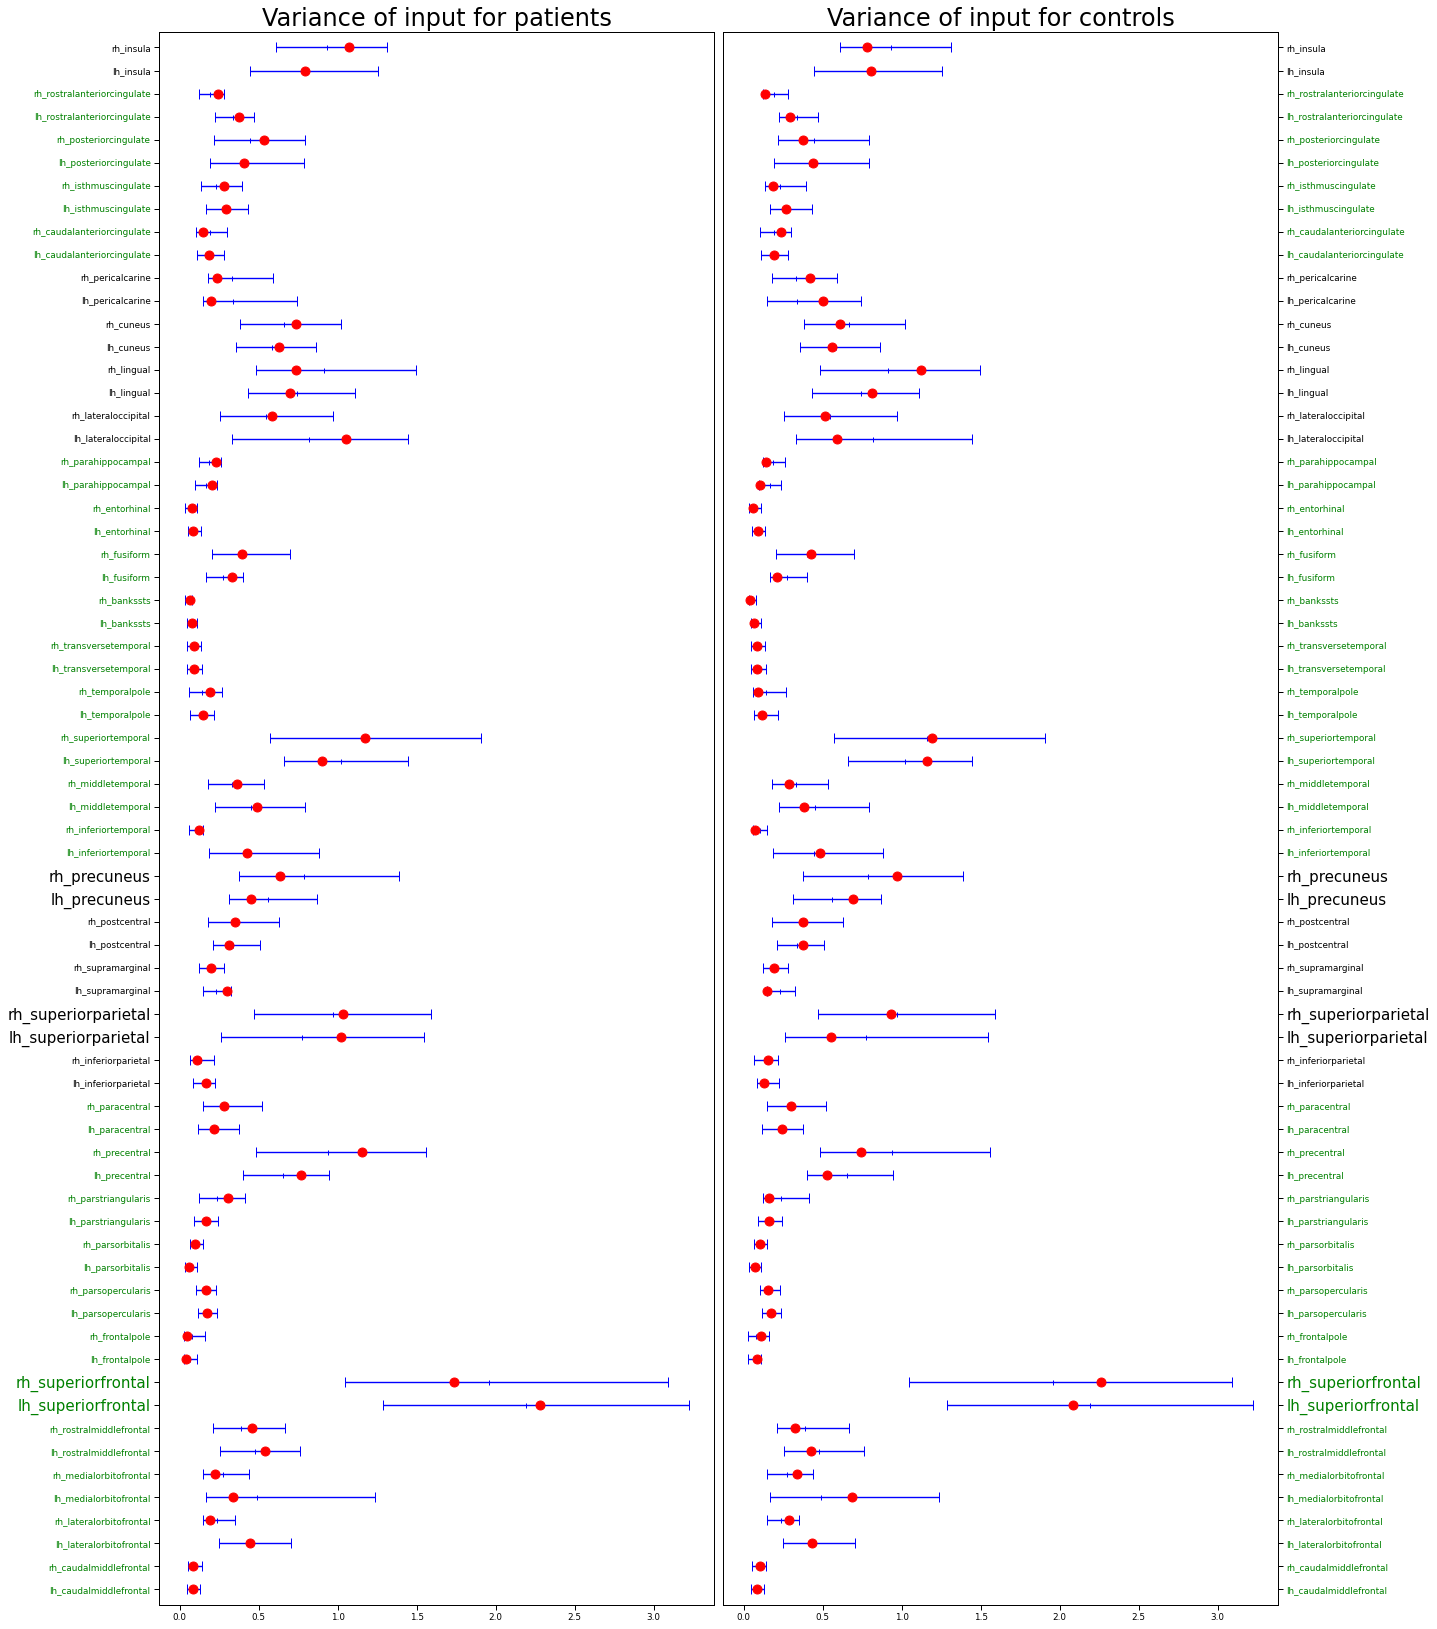

Patients: The parameter value lies above the mean of the values the parameter takes for the permuted groups for
	 40 of 68 rois.
Controls: The parameter value lies above the mean of the values the parameter takes for the permuted groups for
	 30 of 68 rois.
Patients: lh values are greater than rh values for 17 of 34 rois.
Controls: lh values are greater than rh values for 15 of 34 rois.
The mean of the patient's values are smaller than the control's for 30 rois.
For the frontal lobe it is smaller for 11 of 22 rois.
For the temporal lobe it is smaller for 6 of 18 rois.
For the parietal lobe it is smaller for 5 of 10 rois.
For the occipital lobe it is smaller for 3 of 8 rois.
For the cingulate lobe it is smaller for 4 of 8 rois.


In [392]:
## Examine significance of variance of rc input (feeder)
#sample_groupsize = 'matched'#'all subjects'
alpha = 0.95
statistic_description = 'Variance of input'
y_labels = roi_labels
if sample_groupsize== 'matched':
    n_subjects = np.fmin(n_patients, n_controls)
    examine_significance(input_patients[:, :],
                             input_controls[:, :],
                             np.var(input_patients[:n_subjects, :], axis=0),
                             np.var(input_controls[:n_subjects, :], axis=0),
                             statistic_description, y_labels, roi_indexes_categorized, alpha, np.var)
else:
    examine_significance(input_patients[:, :],
                             input_controls[:, :],
                             np.var(input_patients, axis=0),
                             np.var(input_controls, axis=0),
                             statistic_description, y_labels, roi_indexes_categorized, alpha, np.var)

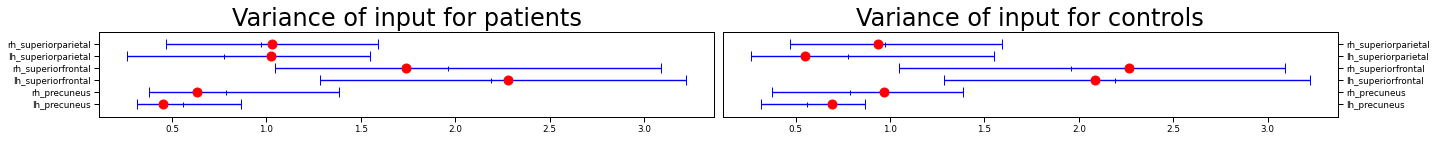

Patients: The parameter value lies above the mean of the values the parameter takes for the permuted groups for
	 3 of 6 rois.
Controls: The parameter value lies above the mean of the values the parameter takes for the permuted groups for
	 3 of 6 rois.
Patients: lh values are greater than rh values for 1 of 3 rois.
Controls: lh values are greater than rh values for 0 of 3 rois.
The mean of the patient's values are smaller than the control's for 3 rois.
For the frontal lobe it is smaller for 3 of 22 rois.
For the temporal lobe it is smaller for 0 of 18 rois.
For the parietal lobe it is smaller for 0 of 10 rois.
For the occipital lobe it is smaller for 0 of 8 rois.
For the cingulate lobe it is smaller for 0 of 8 rois.


In [393]:
## Examine significance of variance of rc input (feeder)
#sample_groupsize = 'matched'#'all subjects'
alpha = 0.95
statistic_description = 'Variance of input'
y_labels = roi_labels
if sample_groupsize== 'matched':
    n_subjects = np.fmin(n_patients, n_controls)
    examine_significance(input_patients[:, :],
                             input_controls[:, :],
                             np.var(input_patients[:n_subjects, :], axis=0),
                             np.var(input_controls[:n_subjects, :], axis=0),
                             statistic_description, y_labels, indexes_rc, alpha, np.var)
else:
    examine_significance(input_patients[:, :],
                             input_controls[:, :],
                             np.var(input_patients, axis=0),
                             np.var(input_controls, axis=0),
                             statistic_description, y_labels, indexes_rc, alpha, np.var)

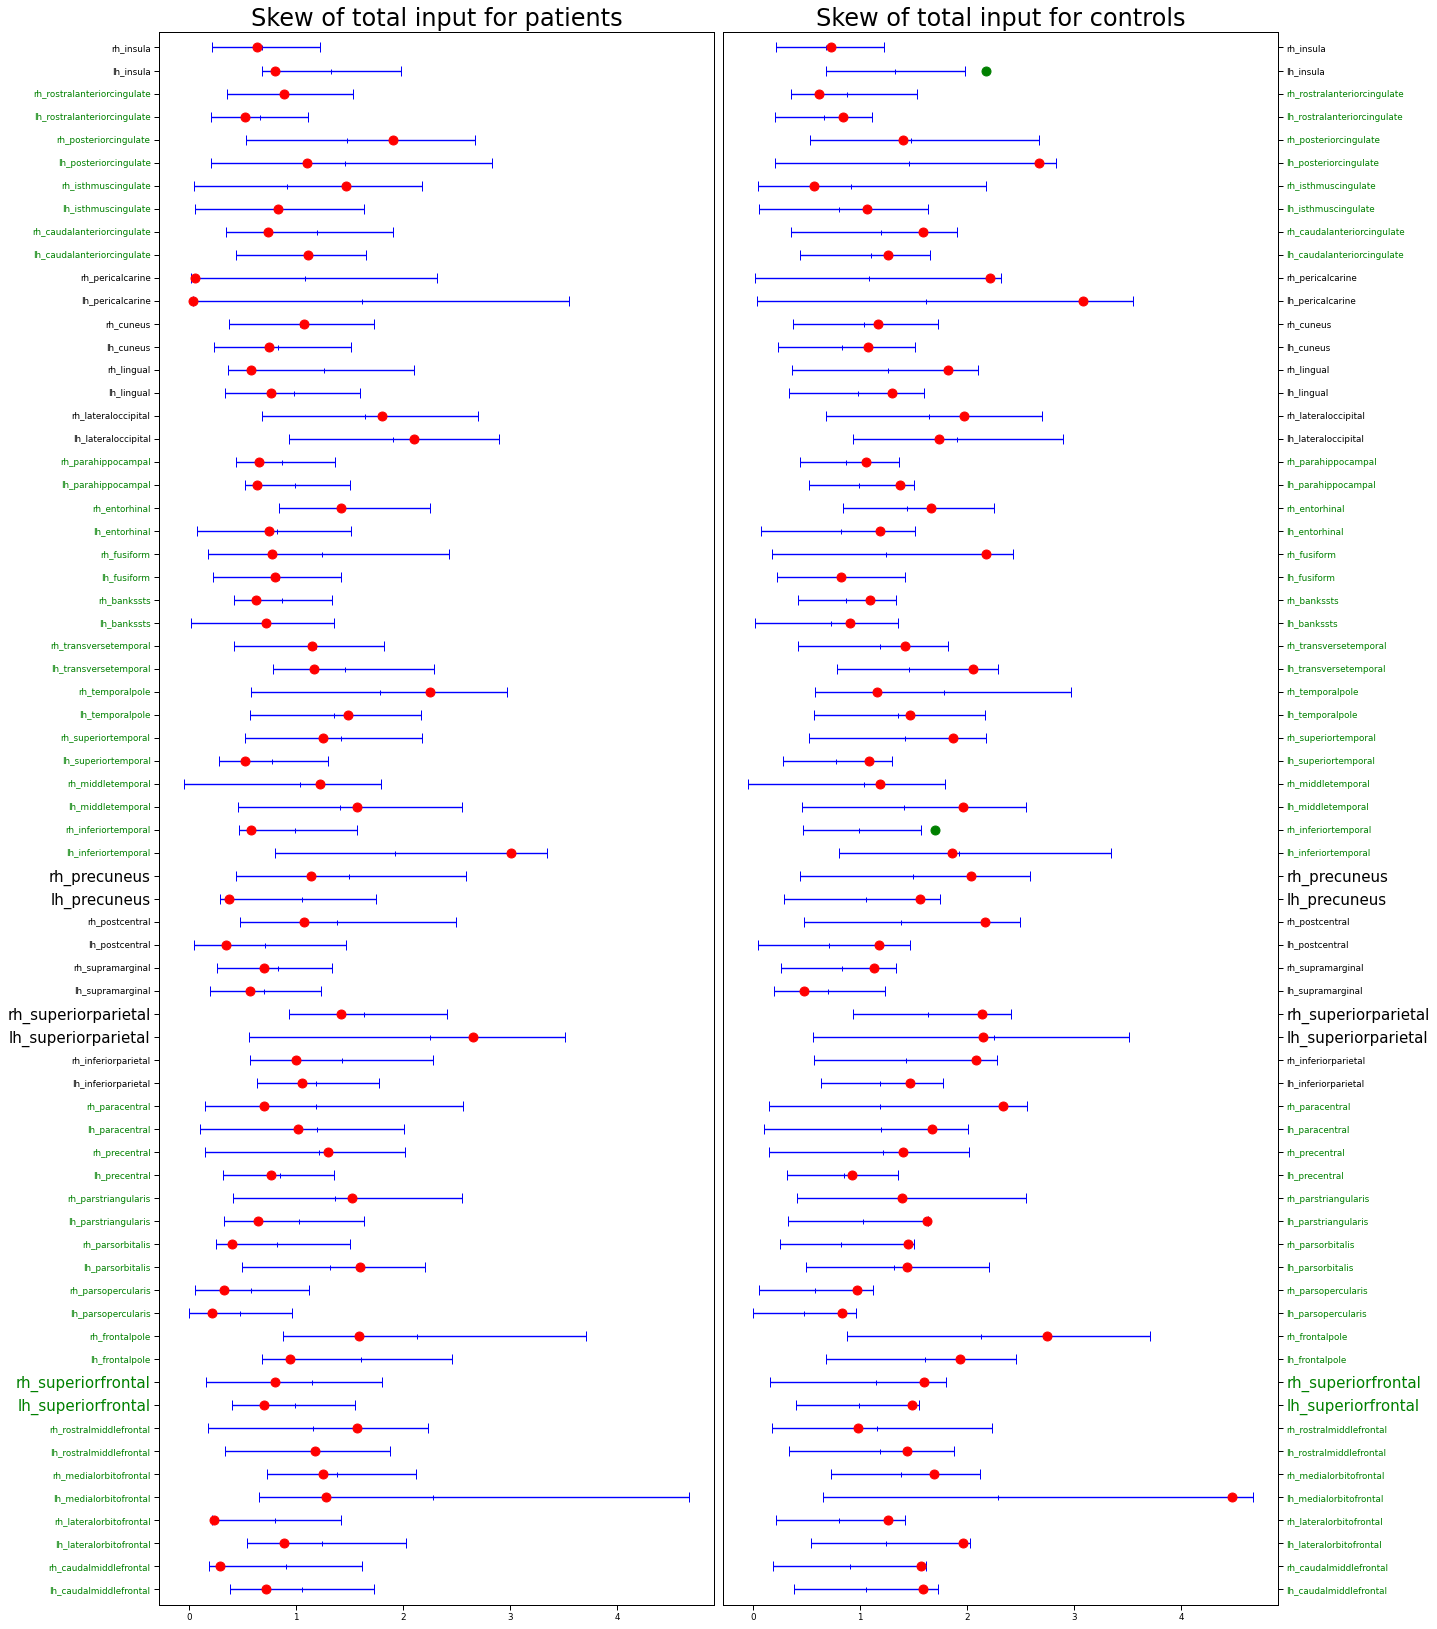

Patients: The parameter value lies above the mean of the values the parameter takes for the permuted groups for
	 18 of 68 rois.
Controls: The parameter value lies above the mean of the values the parameter takes for the permuted groups for
	 58 of 68 rois.
Patients: lh values are greater than rh values for 16 of 34 rois.
Controls: lh values are greater than rh values for 16 of 34 rois.
The mean of the patient's values are smaller than the control's for 55 rois.
For the frontal lobe it is smaller for 18 of 22 rois.
For the temporal lobe it is smaller for 14 of 18 rois.
For the parietal lobe it is smaller for 8 of 10 rois.
For the occipital lobe it is smaller for 7 of 8 rois.
For the cingulate lobe it is smaller for 6 of 8 rois.


In [394]:
## Examine significance of skew of input(feeder)
#sample_groupsize = 'matched'#'all subjects'
alpha = 0.95
statistic_description = 'Skew of total input'
y_labels = roi_labels
if sample_groupsize == 'matched':
    n_subjects = np.fmin(n_patients, n_controls)
    fig = examine_significance(input_patients,
                              input_controls,
                              stt.skew(input_patients[:n_subjects], axis=0),
                              stt.skew(input_controls[:n_subjects], axis=0),
                              statistic_description, y_labels, roi_indexes_categorized, alpha, stt.skew)
else:
    fig = examine_significance(input_patients, input_controls,
                              stt.skew(input_patients, axis=0),
                              stt.skew(input_controls, axis=0),
                              statistic_description, y_labels, roi_indexes_categorized, alpha, stt.skew)
#fig.savefig(str(_FIGURES_DIR + '/skew_all_rois_input_95.png'), bbox_inches='tight')

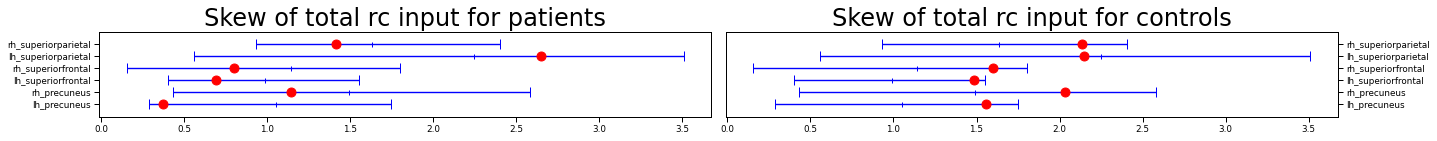

Patients: The parameter value lies above the mean of the values the parameter takes for the permuted groups for
	 1 of 6 rois.
Controls: The parameter value lies above the mean of the values the parameter takes for the permuted groups for
	 5 of 6 rois.
Patients: lh values are greater than rh values for 1 of 3 rois.
Controls: lh values are greater than rh values for 1 of 3 rois.
The mean of the patient's values are smaller than the control's for 5 rois.
For the frontal lobe it is smaller for 5 of 22 rois.
For the temporal lobe it is smaller for 0 of 18 rois.
For the parietal lobe it is smaller for 0 of 10 rois.
For the occipital lobe it is smaller for 0 of 8 rois.
For the cingulate lobe it is smaller for 0 of 8 rois.


In [395]:
## Examine significance of skew of input(feeder)
#sample_groupsize = 'matched'#'all subjects'
alpha = 0.95
statistic_description = 'Skew of total rc input'
y_labels = roi_labels
if sample_groupsize== 'matched':
    n_subjects = np.fmin(n_patients, n_controls)
    examine_significance(input_patients,
                              input_controls,
                              stt.skew(input_patients[:n_subjects], axis=0),
                              stt.skew(input_controls[:n_subjects], axis=0),
                              statistic_description, y_labels, indexes_rc, alpha, stt.skew)
else:
    examine_significance(input_patients, input_controls,
                              stt.skew(input_patients, axis=0),
                              stt.skew(input_controls, axis=0),
                              statistic_description, y_labels, indexes_rc, alpha, stt.skew)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1082: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - np.expand_dims(np.mean(a, axis), axis)


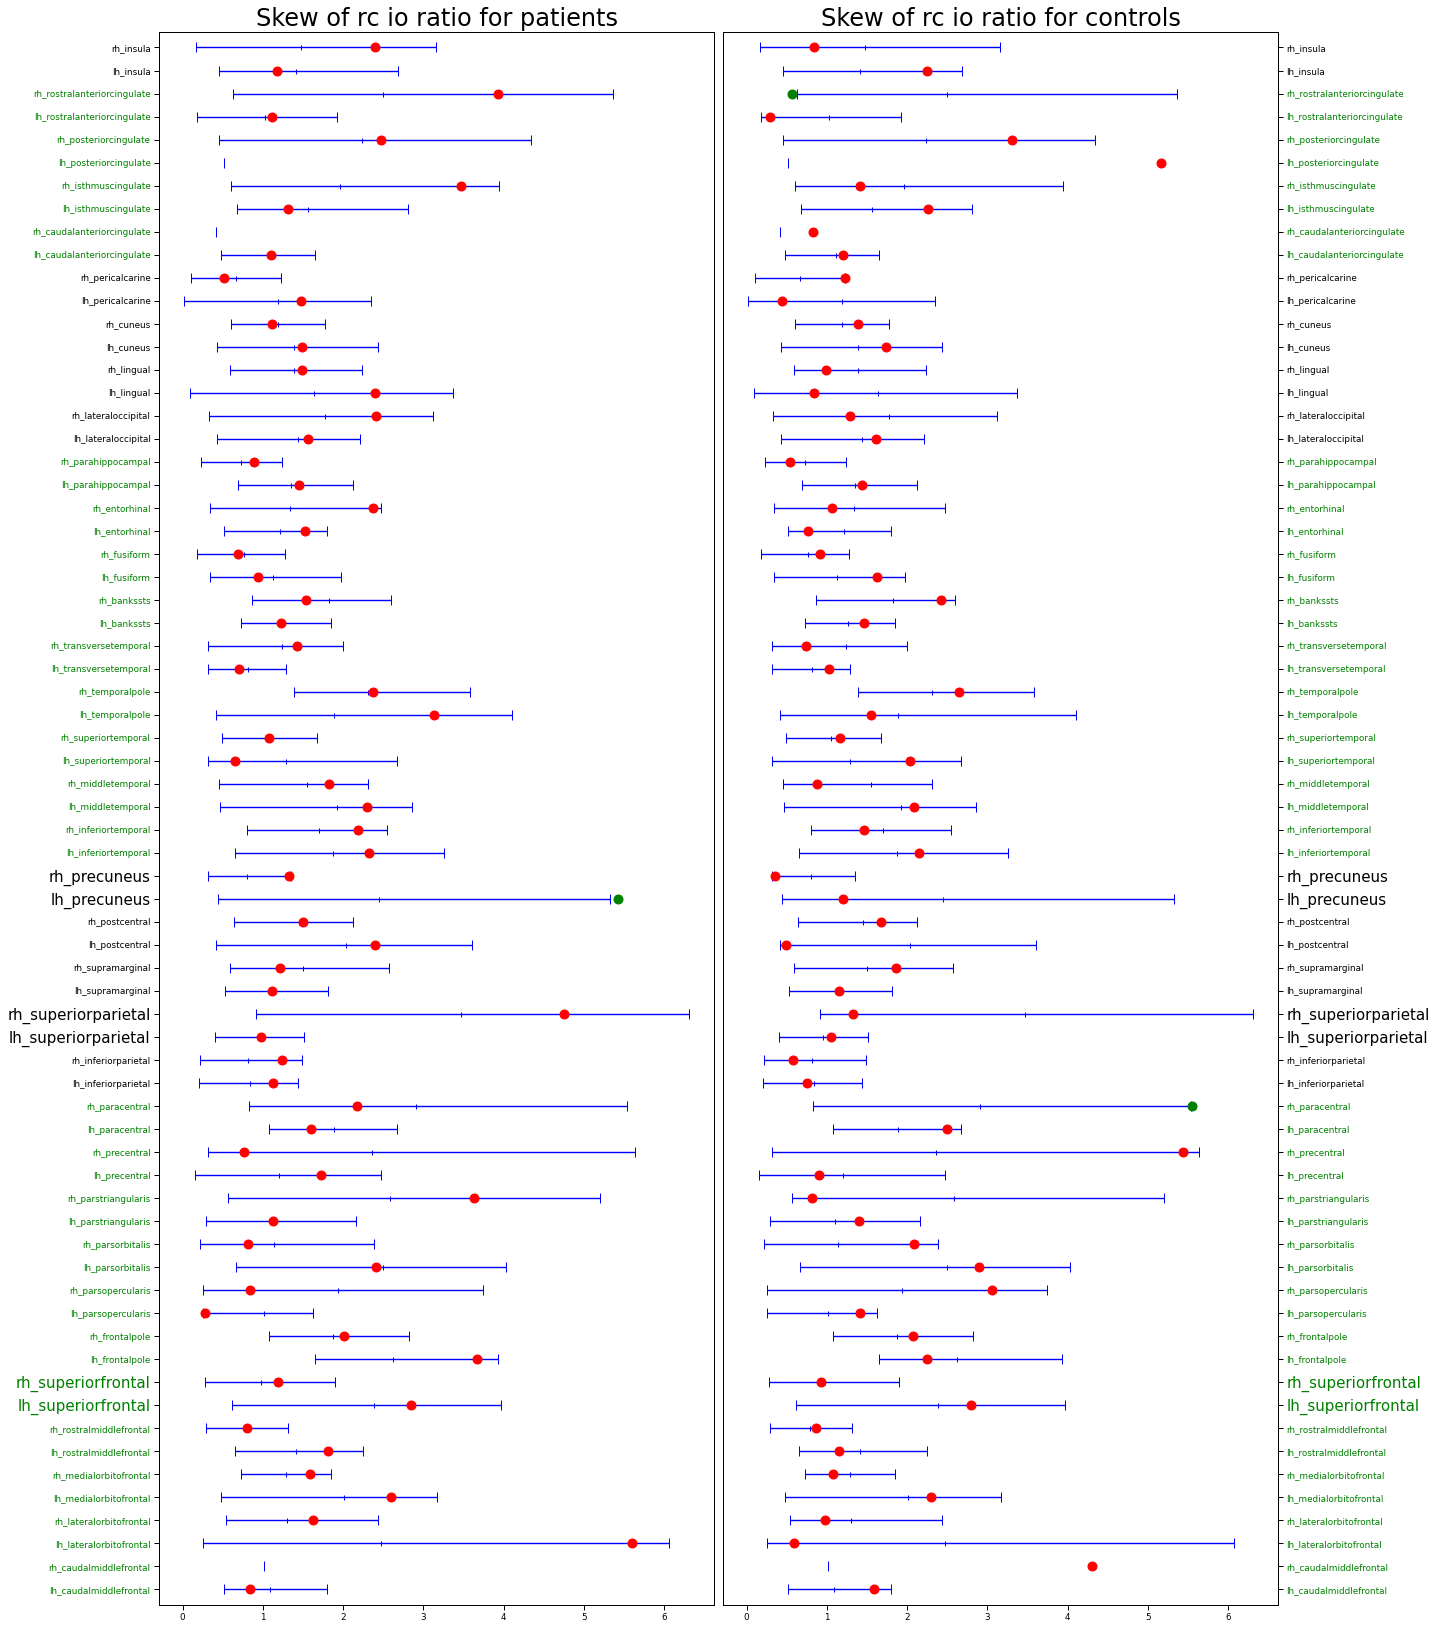

Patients: The parameter value lies above the mean of the values the parameter takes for the permuted groups for
	 44 of 68 rois.
Controls: The parameter value lies above the mean of the values the parameter takes for the permuted groups for
	 36 of 68 rois.
Patients: lh values are greater than rh values for 17 of 34 rois.
Controls: lh values are greater than rh values for 20 of 34 rois.
The mean of the patient's values are smaller than the control's for 31 rois.
For the frontal lobe it is smaller for 10 of 22 rois.
For the temporal lobe it is smaller for 8 of 18 rois.
For the parietal lobe it is smaller for 5 of 10 rois.
For the occipital lobe it is smaller for 3 of 8 rois.
For the cingulate lobe it is smaller for 4 of 8 rois.


In [396]:
## Examine significance of skew of input(feeder)
alpha = 0.95
sample_groupsize = 'matched'
#sample_groupsize = 'all subjects'
statistic_description = 'Skew of rc io ratio'
y_labels = roi_labels
if sample_groupsize== 'matched':
    n_subjects = np.fmin(n_patients, n_controls)
    examine_significance(io_ratio_patients,
                              io_ratio_controls,
                              stt.skew(io_ratio_patients[:n_subjects], axis=0),
                              stt.skew(io_ratio_controls[:n_subjects], axis=0),
                              statistic_description, y_labels, roi_indexes_categorized, alpha, stt.skew)
else:
    examine_significance(io_ratio_patients, io_ratio_controls,
                              stt.skew(io_ratio_patients, axis=0),
                              stt.skew(io_ratio_controls, axis=0),
                              statistic_description, y_labels, roi_indexes_categorized, alpha, stt.skew)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1082: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - np.expand_dims(np.mean(a, axis), axis)


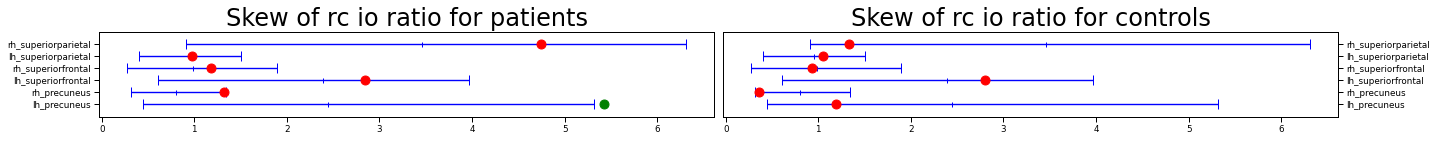

Patients: The parameter value lies above the mean of the values the parameter takes for the permuted groups for
	 6 of 6 rois.
Controls: The parameter value lies above the mean of the values the parameter takes for the permuted groups for
	 2 of 6 rois.
Patients: lh values are greater than rh values for 2 of 3 rois.
Controls: lh values are greater than rh values for 2 of 3 rois.
The mean of the patient's values are smaller than the control's for 1 rois.
For the frontal lobe it is smaller for 1 of 22 rois.
For the temporal lobe it is smaller for 0 of 18 rois.
For the parietal lobe it is smaller for 0 of 10 rois.
For the occipital lobe it is smaller for 0 of 8 rois.
For the cingulate lobe it is smaller for 0 of 8 rois.


In [397]:
## Examine significance of skew of input(feeder)
alpha = 0.95
sample_groupsize = 'matched'
#sample_groupsize = 'all subjects'
statistic_description = 'Skew of rc io ratio'
y_labels = roi_labels
if sample_groupsize== 'matched':
    n_subjects = np.fmin(n_patients, n_controls)
    examine_significance(io_ratio_patients,
                              io_ratio_controls,
                              stt.skew(io_ratio_patients[:n_subjects], axis=0),
                              stt.skew(io_ratio_controls[:n_subjects], axis=0),
                              statistic_description, y_labels, indexes_rc, alpha, stt.skew)
else:
    examine_significance(io_ratio_patients, io_ratio_controls,
                              stt.skew(io_ratio_patients, axis=0),
                              stt.skew(io_ratio_controls, axis=0),
                              statistic_description, y_labels, indexes_rc, alpha, stt.skew)

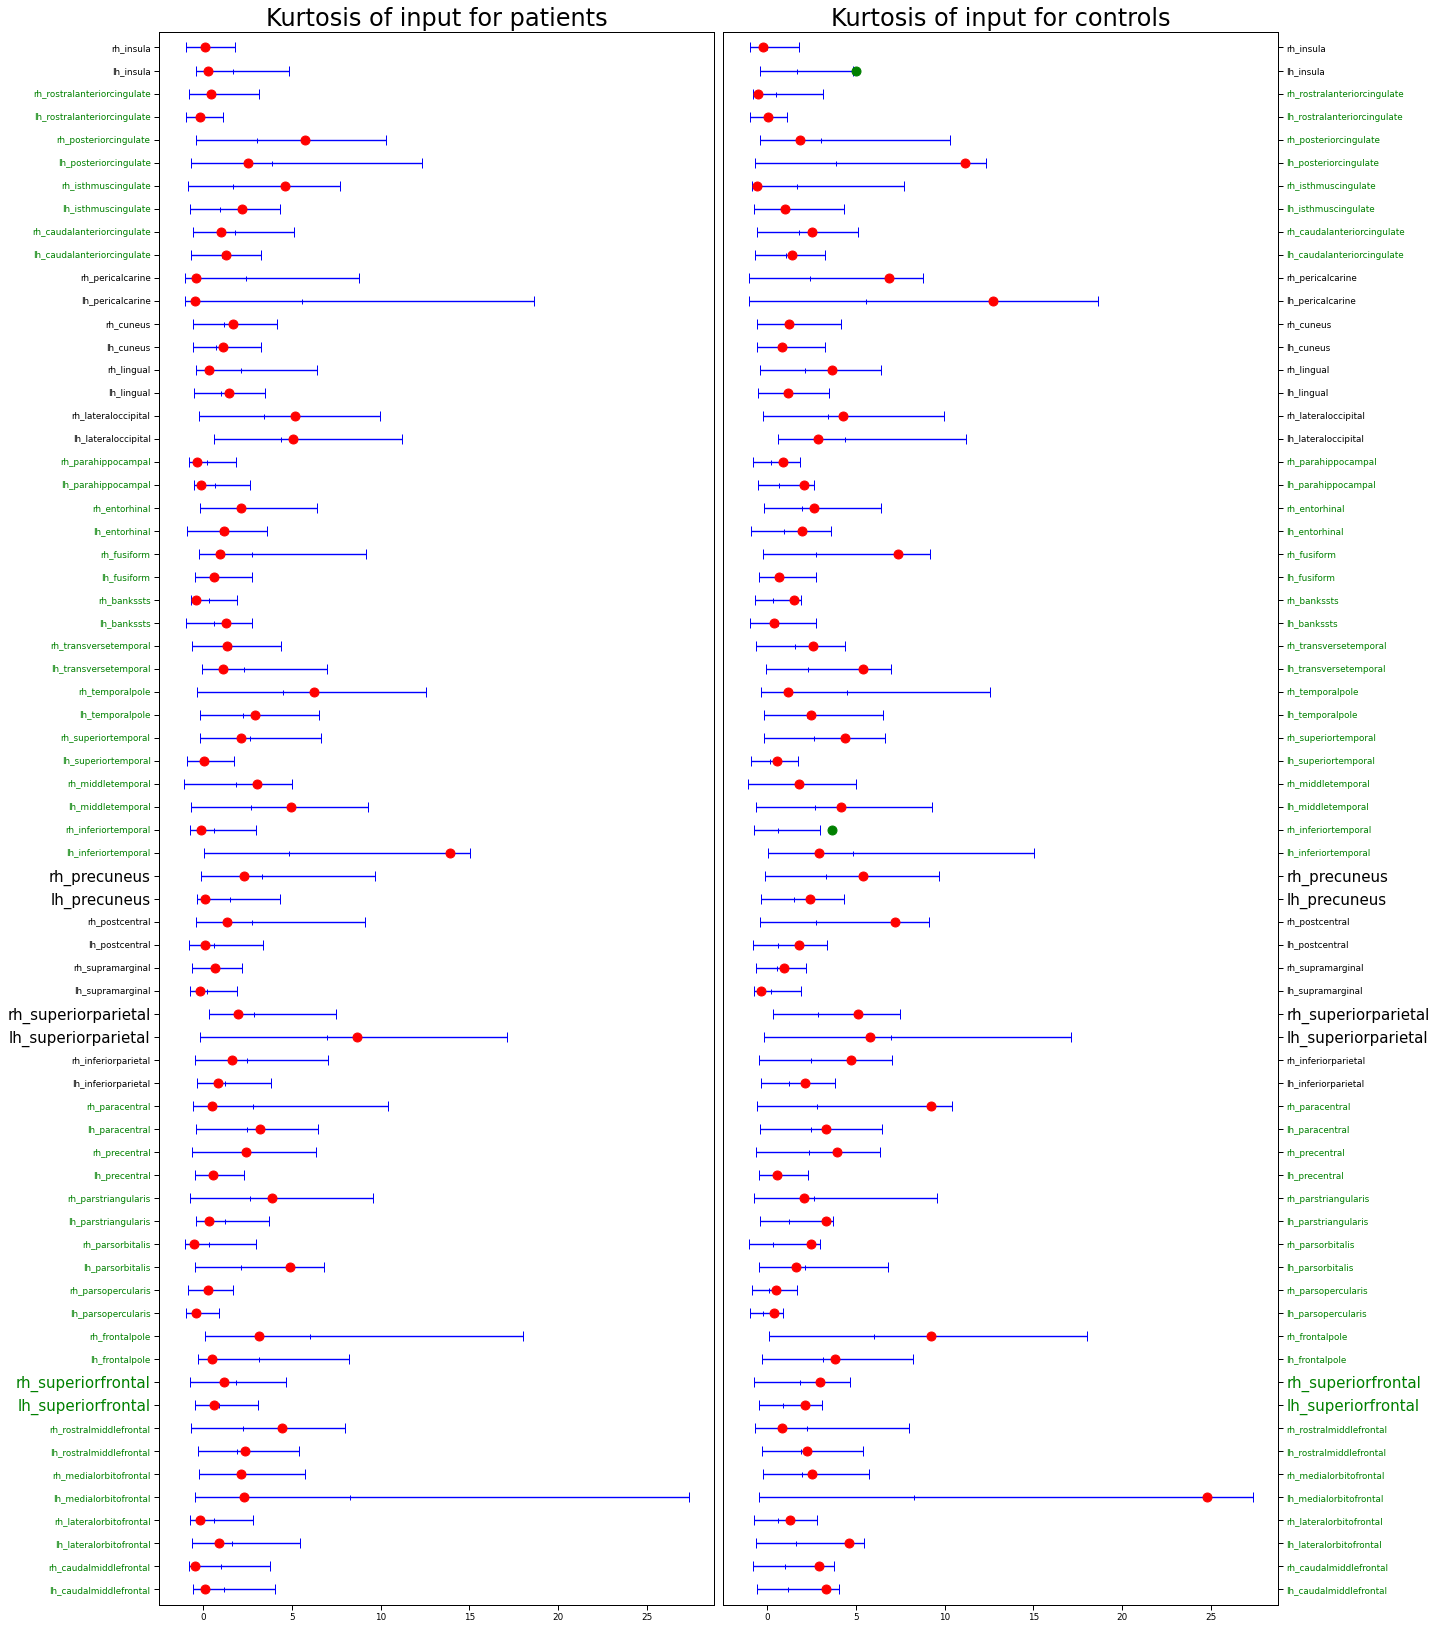

Patients: The parameter value lies above the mean of the values the parameter takes for the permuted groups for
	 28 of 68 rois.
Controls: The parameter value lies above the mean of the values the parameter takes for the permuted groups for
	 52 of 68 rois.
Patients: lh values are greater than rh values for 13 of 34 rois.
Controls: lh values are greater than rh values for 15 of 34 rois.
The mean of the patient's values are smaller than the control's for 46 rois.
For the frontal lobe it is smaller for 17 of 22 rois.
For the temporal lobe it is smaller for 12 of 18 rois.
For the parietal lobe it is smaller for 8 of 10 rois.
For the occipital lobe it is smaller for 3 of 8 rois.
For the cingulate lobe it is smaller for 5 of 8 rois.


In [398]:
## Examine significance of kurtosis of input(feeder)
#sample_groupsize = 'matched'#'all subjects'
alpha = 0.95
statistic_description = 'Kurtosis of input'
y_labels = roi_labels
if sample_groupsize== 'matched':
    n_subjects = np.fmin(n_patients, n_controls)
    examine_significance(input_patients,
                              input_controls,
                              stt.kurtosis(input_patients[:n_subjects], axis=0),
                              stt.kurtosis(input_controls[:n_subjects], axis=0),
                              statistic_description, y_labels, roi_indexes_categorized, alpha, stt.kurtosis)
else:
    examine_significance(input_patients, input_controls,
                              stt.kurtosis(input_patients, axis=0),
                              stt.kurtosis(input_controls, axis=0),
                              statistic_description, y_labels, roi_indexes_categorized, alpha, stt.kurtosis)

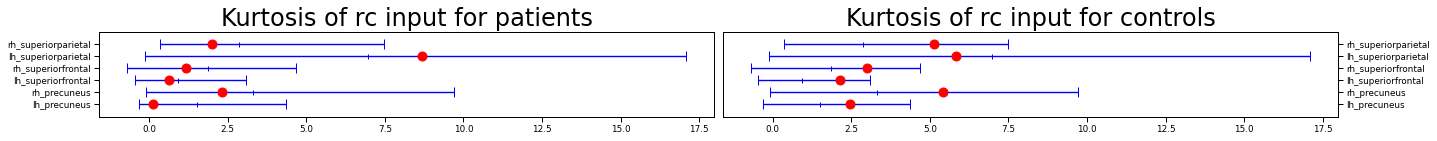

Patients: The parameter value lies above the mean of the values the parameter takes for the permuted groups for
	 1 of 6 rois.
Controls: The parameter value lies above the mean of the values the parameter takes for the permuted groups for
	 5 of 6 rois.
Patients: lh values are greater than rh values for 1 of 3 rois.
Controls: lh values are greater than rh values for 1 of 3 rois.
The mean of the patient's values are smaller than the control's for 5 rois.
For the frontal lobe it is smaller for 5 of 22 rois.
For the temporal lobe it is smaller for 0 of 18 rois.
For the parietal lobe it is smaller for 0 of 10 rois.
For the occipital lobe it is smaller for 0 of 8 rois.
For the cingulate lobe it is smaller for 0 of 8 rois.


In [399]:
## Examine significance of kurtosis of input(feeder)
#sample_groupsize = 'matched'#'all subjects'
alpha = 0.95
statistic_description = 'Kurtosis of rc input'
y_labels = roi_labels
if sample_groupsize== 'matched':
    n_subjects = np.fmin(n_patients, n_controls)
    examine_significance(input_patients,
                              input_controls,
                              stt.kurtosis(input_patients[:n_subjects], axis=0),
                              stt.kurtosis(input_controls[:n_subjects], axis=0),
                              statistic_description, y_labels, indexes_rc, alpha, stt.kurtosis)
else:
    examine_significance(input_patients, input_controls,
                              stt.kurtosis(input_patients, axis=0),
                              stt.kurtosis(input_controls, axis=0),
                              statistic_description, y_labels, indexes_rc, alpha, stt.kurtosis)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1082: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - np.expand_dims(np.mean(a, axis), axis)


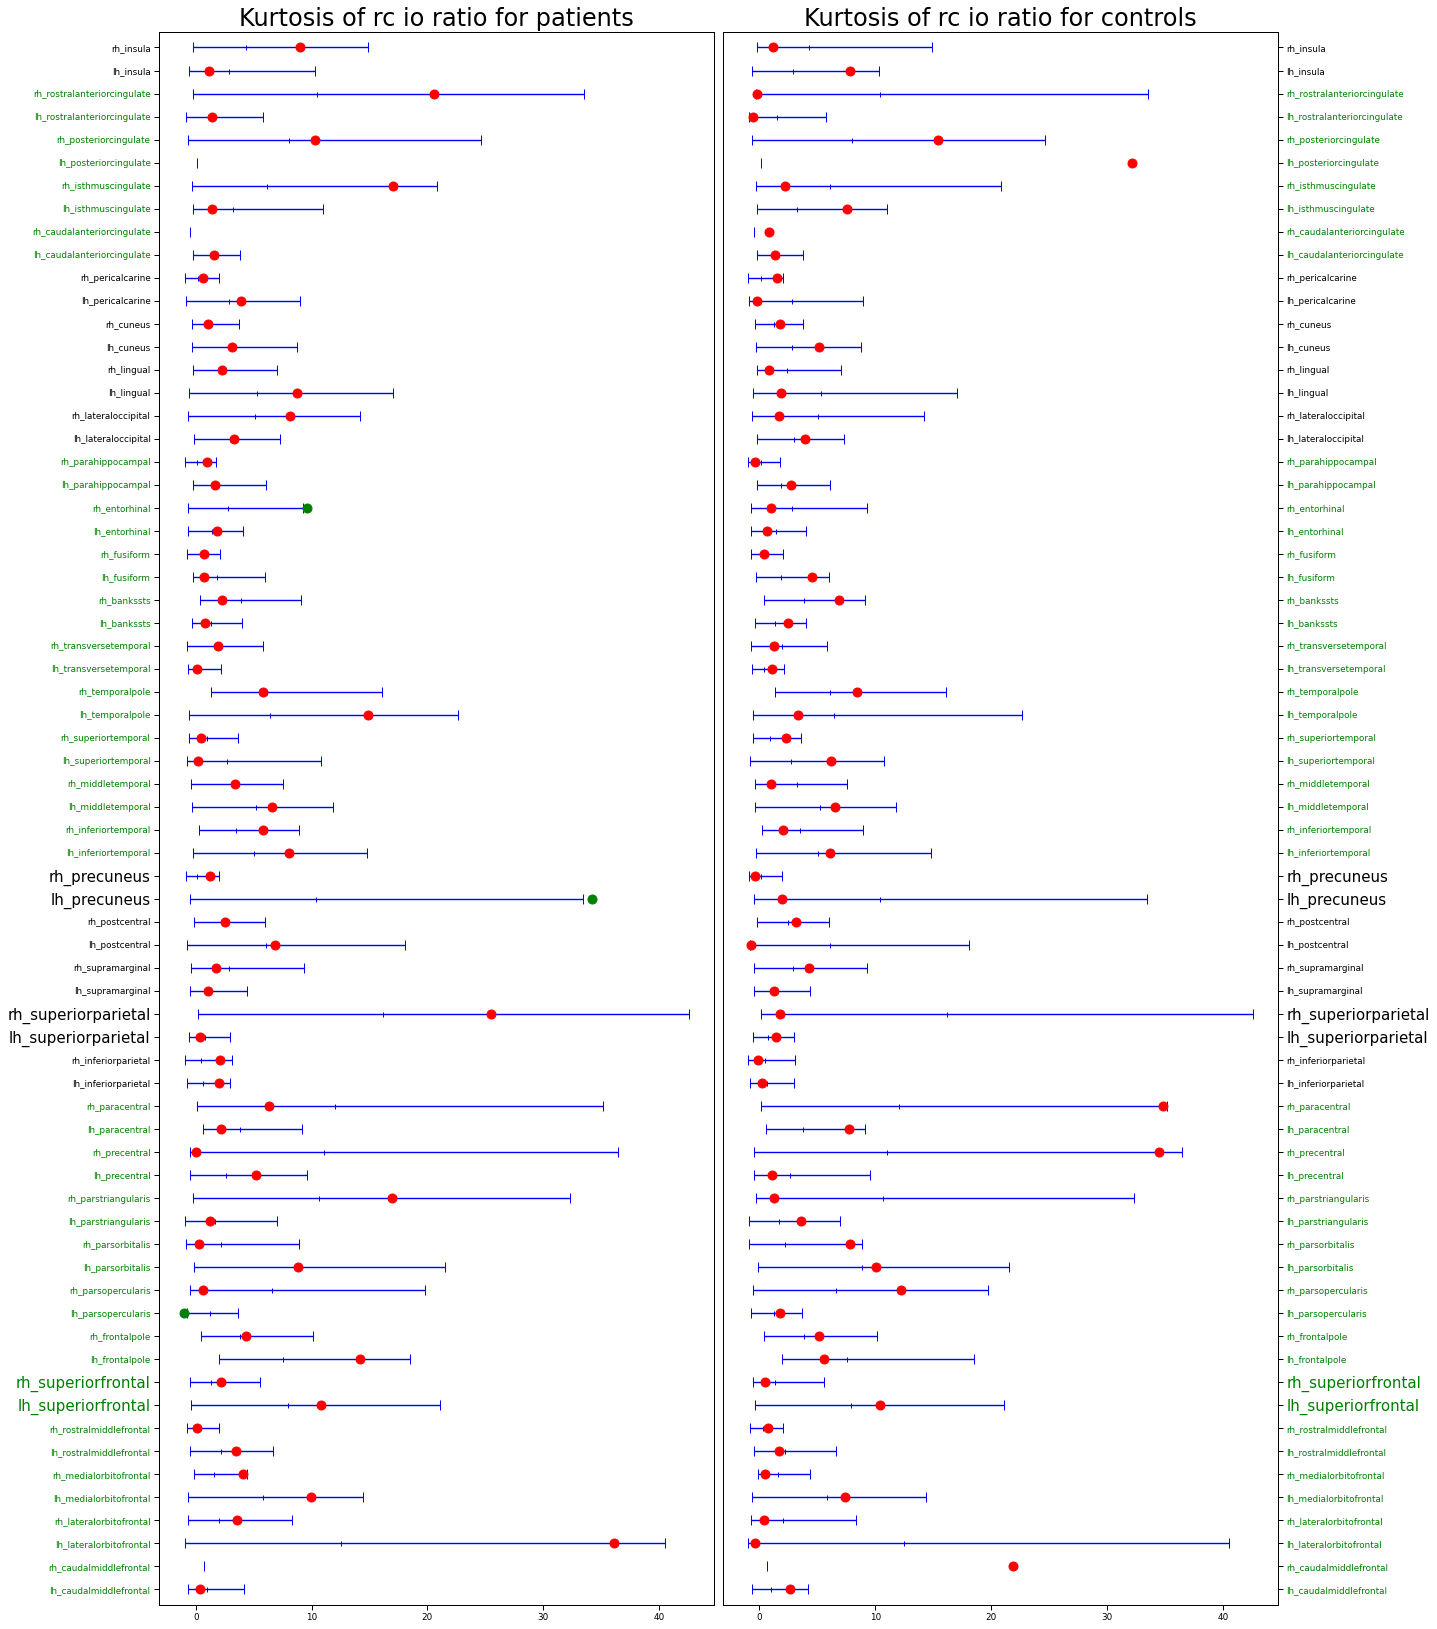

Patients: The parameter value lies above the mean of the values the parameter takes for the permuted groups for
	 38 of 68 rois.
Controls: The parameter value lies above the mean of the values the parameter takes for the permuted groups for
	 34 of 68 rois.
Patients: lh values are greater than rh values for 17 of 34 rois.
Controls: lh values are greater than rh values for 20 of 34 rois.
The mean of the patient's values are smaller than the control's for 30 rois.
For the frontal lobe it is smaller for 10 of 22 rois.
For the temporal lobe it is smaller for 8 of 18 rois.
For the parietal lobe it is smaller for 5 of 10 rois.
For the occipital lobe it is smaller for 3 of 8 rois.
For the cingulate lobe it is smaller for 3 of 8 rois.


In [400]:
## Examine significance of kurtosis of input(feeder)
#sample_groupsize = 'matched'#'all subjects'
alpha = 0.95
statistic_description = 'Kurtosis of rc io ratio'
y_labels = roi_labels
if sample_groupsize== 'matched':
    n_subjects = np.fmin(n_patients, n_controls)
    examine_significance(io_ratio_patients,
                              io_ratio_controls,
                              stt.kurtosis(io_ratio_patients[:n_subjects], axis=0),
                              stt.kurtosis(io_ratio_controls[:n_subjects], axis=0),
                              statistic_description, y_labels, roi_indexes_categorized, alpha, stt.kurtosis)
else:
    examine_significance(io_ratio_patients, io_ratio_controls,
                              stt.kurtosis(io_ratio_patients, axis=0),
                              stt.kurtosis(io_ratio_controls, axis=0),
                              statistic_description, y_labels, roi_indexes_categorized, alpha, stt.kurtosis)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1082: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - np.expand_dims(np.mean(a, axis), axis)


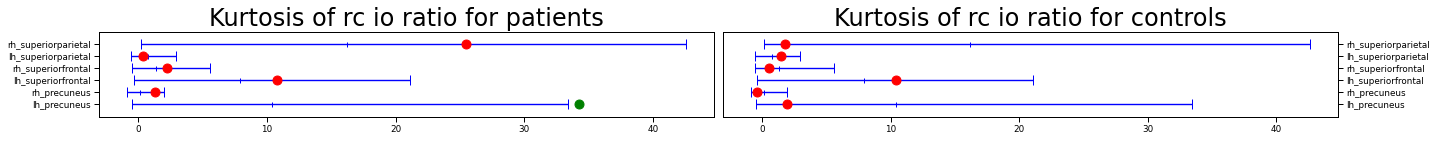

Patients: The parameter value lies above the mean of the values the parameter takes for the permuted groups for
	 5 of 6 rois.
Controls: The parameter value lies above the mean of the values the parameter takes for the permuted groups for
	 2 of 6 rois.
Patients: lh values are greater than rh values for 2 of 3 rois.
Controls: lh values are greater than rh values for 2 of 3 rois.
The mean of the patient's values are smaller than the control's for 1 rois.
For the frontal lobe it is smaller for 1 of 22 rois.
For the temporal lobe it is smaller for 0 of 18 rois.
For the parietal lobe it is smaller for 0 of 10 rois.
For the occipital lobe it is smaller for 0 of 8 rois.
For the cingulate lobe it is smaller for 0 of 8 rois.


In [401]:
## Examine significance of kurtosis of input(feeder)
#sample_groupsize = 'matched'#'all subjects'
alpha = 0.95
statistic_description = 'Kurtosis of rc io ratio'
y_labels = roi_labels
if sample_groupsize== 'matched':
    n_subjects = np.fmin(n_patients, n_controls)
    examine_significance(io_ratio_patients,
                              io_ratio_controls,
                              stt.kurtosis(io_ratio_patients[:n_subjects], axis=0),
                              stt.kurtosis(io_ratio_controls[:n_subjects], axis=0),
                              statistic_description, y_labels, indexes_rc, alpha, stt.kurtosis)
else:
    examine_significance(io_ratio_patients, io_ratio_controls,
                              stt.kurtosis(io_ratio_patients, axis=0),
                              stt.kurtosis(io_ratio_controls, axis=0),
                              statistic_description, y_labels, indexes_rc, alpha, stt.kurtosis)

In [402]:
## Examine tendency of nodes being either predominantly sender or receiver (patients).
# Input and output greater than mean.
i_and_o_g_patients = np.logical_and(input_patients[:n_subjects,roi_indexes_categorized].mean(axis=0) >= input_patients[:n_subjects, roi_indexes_categorized].mean(), output_patients[:n_subjects, roi_indexes_categorized].mean(axis=0) >= output_patients[:n_subjects, roi_indexes_categorized].mean())
# Either input or output greater than mean (exclusive).
i_or_o_g_patients = np.logical_xor(input_patients[:n_subjects, roi_indexes_categorized].mean(axis=0) >= input_patients[:n_subjects, roi_indexes_categorized].mean(), output_patients[:n_subjects, roi_indexes_categorized].mean(axis=0) >= output_patients[:n_subjects, roi_indexes_categorized].mean())
# Input and output lesser than mean.
i_and_o_l_patients = np.logical_and(input_patients[:n_subjects,roi_indexes_categorized].mean(axis=0) < input_patients[:n_subjects, roi_indexes_categorized].mean(), output_patients[:n_subjects, roi_indexes_categorized].mean(axis=0) < output_patients[:n_subjects, roi_indexes_categorized].mean())

with np.printoptions(threshold=np.inf):
    print(i_and_o_g_patients.astype(int).sum())
    print(i_or_o_g_patients.astype(int).sum())
    print(i_and_o_l_patients.astype(int).sum())

20
22
26


In [403]:
## Examine tendency of nodes being either predominantly sender or receiver (controls).
# Input and output greater than mean.
i_and_o_g_controls = np.logical_and(input_controls[:n_subjects,roi_indexes_categorized].mean(axis=0) >= input_controls[:n_subjects, roi_indexes_categorized].mean(), output_controls[:n_subjects, roi_indexes_categorized].mean(axis=0) >= output_controls[:n_subjects, roi_indexes_categorized].mean())
# Either input or output greater than mean (exclusive).
i_or_o_g_controls = np.logical_xor(input_controls[:n_subjects, roi_indexes_categorized].mean(axis=0) >= input_controls[:n_subjects, roi_indexes_categorized].mean(), output_controls[:n_subjects, roi_indexes_categorized].mean(axis=0) >= output_controls[:n_subjects, roi_indexes_categorized].mean())
# Input and output lesser than mean.
i_and_o_l_controls = np.logical_and(input_controls[:n_subjects,roi_indexes_categorized].mean(axis=0) < input_controls[:n_subjects, roi_indexes_categorized].mean(), output_controls[:n_subjects, roi_indexes_categorized].mean(axis=0) < output_controls[:n_subjects, roi_indexes_categorized].mean())

with np.printoptions(threshold=np.inf):
    print(i_and_o_g_controls.astype(int).sum())
    print(i_or_o_g_controls.astype(int).sum())
    print(i_and_o_l_controls.astype(int).sum())
    
# Number of connections that are greater (or lesser) than the mean with respect to the input.
print(np.logical_and(i_and_o_g_patients.astype(int), i_and_o_g_controls.astype(int)).sum())
print(np.logical_and(i_or_o_g_patients.astype(int), i_or_o_g_controls.astype(int)).sum())
print(np.logical_and(i_and_o_l_patients.astype(int), i_and_o_l_controls.astype(int)).sum())

19
19
30
16
14
24


In [495]:
# Create a 2D-mask for inter periphery connections.
indexes_rich_club = [23, 26, 27, 57, 60, 61]
mask_inter_periph = np.zeros([n_rois, n_rois], dtype=bool)
periph_ind_combin = np.array(list(itertools.product(list(
    x for x in range(68) if x not in indexes_rich_club), repeat=2))).T
mask_inter_periph[periph_ind_combin[0], periph_ind_combin[1]] = True

# Create a 2D-mask for inter rich club connections.
mask_inter_rc = np.zeros([n_rois, n_rois], dtype=bool)
rc_ind_combin = np.array(list(
    itertools.product(indexes_rich_club, repeat=2))).T
mask_inter_rc[rc_ind_combin[0], rc_ind_combin[1]] = True

# Filter out interesting set of connections.
C_patients_avg = C_patients.mean(axis=0)
C_controls_avg = C_controls.mean(axis=0)
C_patients_avg[~mask_inter_periph] = 0
C_controls_avg[~mask_inter_periph] = 0


patients_diff = (C_patients_avg - C_patients_avg.T)
controls_diff = (C_controls_avg - C_controls_avg.T)
max_diff = max(patients_diff.max(), controls_diff.max())
factor = 0.3
(np.abs(C_patients_avg)>factor*max_diff).sum()

306

<ipython-input-497-506fa89549a1>:55: RuntimeWarning: invalid value encountered in long_scalars
  y1 = np.array([(controls_diff[mask_controls_greater]> patients_diff[mask_controls_greater]).sum() / mask_controls_greater.sum() for mask_controls_greater in masks_controls_greater])
<ipython-input-497-506fa89549a1>:56: RuntimeWarning: invalid value encountered in long_scalars
  y2 = np.array([(controls_diff[mask_controls_smaller]< patients_diff[mask_controls_smaller]).sum() / mask_controls_smaller.sum() for mask_controls_smaller in masks_controls_smaller])


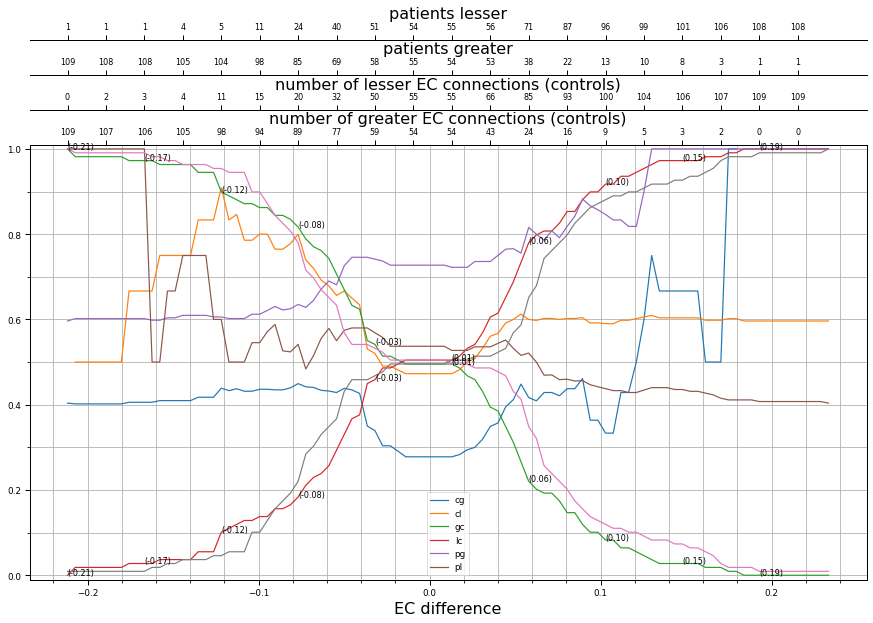

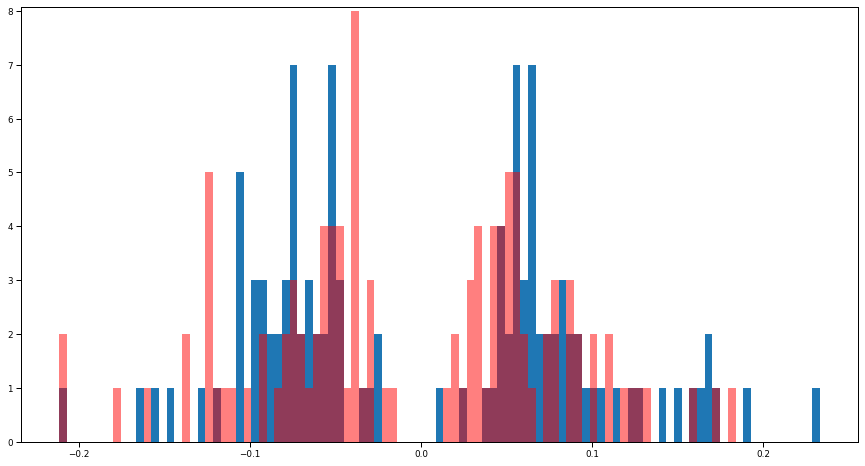

In [497]:
## Examine tendency of big forward-backward difference connections to show 
# bigger difference than the same connections in the other group.

# Create a 2D-mask for inter periphery connections.
indexes_rich_club = [23, 26, 27, 57, 60, 61]
mask_inter_periph = np.zeros([n_rois, n_rois], dtype=bool)
periph_ind_combin = np.array(list(itertools.product(list(
    x for x in range(68) if x not in indexes_rich_club), repeat=2))).T
mask_inter_periph[periph_ind_combin[0], periph_ind_combin[1]] = True

# Create a 2D-mask for inter rich club connections.
mask_inter_rc = np.zeros([n_rois, n_rois], dtype=bool)
rc_ind_combin = np.array(list(
    itertools.product(indexes_rich_club, repeat=2))).T
mask_inter_rc[rc_ind_combin[0], rc_ind_combin[1]] = True

# Filter out interesting set of connections.
C_patients_avg = C_patients.mean(axis=0)
C_controls_avg = C_controls.mean(axis=0)
C_patients_avg[~mask_inter_periph] = 0
C_controls_avg[~mask_inter_periph] = 0
#C_patients_avg[mask_inter_rc] = 0
#C_controls_avg[mask_inter_rc] = 0

#mask_nonzero = np.logical_or(C_patients_avg!=0, C_controls_avg!=0)
#mask_nonzero[~(mask_nonzero == mask_nonzero.T)] = True
#
#patients_diff = np.abs(C_patients_avg - C_patients_avg.T)[np.tril(mask_nonzero)]
#controls_diff = np.abs(C_controls_avg - C_controls_avg.T)[np.tril(mask_nonzero)]
#patients_diff = (C_patients_avg - C_patients_avg.T)[np.triu(mask_nonzero)]
#controls_diff = (C_controls_avg - C_controls_avg.T)[np.triu(mask_nonzero)]

patients_diff = (C_patients_avg - C_patients_avg.T)
controls_diff = (C_controls_avg - C_controls_avg.T)
max_diff = max(patients_diff.max(), controls_diff.max())
factor = 0.2
mask_nonzero = np.logical_or(np.abs(patients_diff)>factor*max_diff, np.abs(controls_diff)>factor*max_diff)
#mask_nonzero[~(mask_nonzero == mask_nonzero.T)] = True
patients_diff = (C_patients_avg - C_patients_avg.T)[np.triu(mask_nonzero)]
controls_diff = (C_controls_avg - C_controls_avg.T)[np.triu(mask_nonzero)]


fig1, ax1 = plt.subplots(figsize=(15,8), num=0)
ax2 = ax1.twiny()
ax3 = ax1.twiny()
ax3.spines['top'].set_position(('outward', 35))
ax4 = ax1.twiny()
ax4.spines['top'].set_position(('outward', 70))
ax5 = ax1.twiny()
ax5.spines['top'].set_position(('outward', 105))

x = np.linspace(min(controls_diff.min(), patients_diff.min()), max(controls_diff.max(), patients_diff.max()),100)
masks_controls_greater = [controls_diff >= i for i in x]
masks_controls_smaller = [controls_diff <= i for i in x]
y1 = np.array([(controls_diff[mask_controls_greater]> patients_diff[mask_controls_greater]).sum() / mask_controls_greater.sum() for mask_controls_greater in masks_controls_greater])
y2 = np.array([(controls_diff[mask_controls_smaller]< patients_diff[mask_controls_smaller]).sum() / mask_controls_smaller.sum() for mask_controls_smaller in masks_controls_smaller])
plt.plot(x,y1)
plt.plot(x,y2)

#x = np.linspace(controls_diff.min(),controls_diff.max(),100)
y1 = np.array([mask_controls_greater.sum()/np.tril(mask_nonzero).sum() for mask_controls_greater in masks_controls_greater])
y2 = np.array([mask_controls_smaller.sum()/np.tril(mask_nonzero).sum() for mask_controls_smaller in masks_controls_smaller])
plt.plot(x,y1)
xlim = plt.xlim()
for xy in zip(x[::10], y1[::10]):
    plt.gca().annotate('(%3.2f)' % xy[0], xy=xy, textcoords='data')
plt.plot(x,y2)
for xy in zip(x[::10], y2[::10]):
    plt.gca().annotate('(%3.2f)' % xy[0], xy=xy, textcoords='data')

minor_locator = AutoMinorLocator(5)
ax1.xaxis.set_minor_locator(minor_locator)
minor_locator = AutoMinorLocator(2)
ax1.yaxis.set_minor_locator(minor_locator)
ax1.grid(which='both')

ax1.set_xlabel("EC difference")
ax1.set_xlim(xlim)

ax2.set_xlabel("number of greater EC connections (controls)")
ax2.set_xlim(xlim)
ax2.set_xticks(x[::5])
ax2.set_xticklabels(np.array([mask_controls_greater.sum() for mask_controls_greater in masks_controls_greater])[::5], fontsize=8)

ax3.set_xlabel("number of lesser EC connections (controls)")
ax3.set_xlim(xlim)
ax3.set_xticks(x[::5])
ax3.set_xticklabels(np.array([mask_controls_smaller.sum() for mask_controls_smaller in masks_controls_smaller])[::5], fontsize=8)

#x = np.linspace(patients_diff.min(),patients_diff.max(),100)
masks_patients_greater = [patients_diff >= i for i in x]
masks_patients_smaller = [patients_diff <= i for i in x]
y1 = np.array([(patients_diff[mask_patients_greater]> controls_diff[mask_patients_greater]).sum() / mask_patients_greater.sum() for mask_patients_greater in masks_patients_greater])
y2 = np.array([(patients_diff[mask_patients_smaller]< controls_diff[mask_patients_smaller]).sum() / mask_patients_smaller.sum() for mask_patients_smaller in masks_patients_smaller])
plt.plot(x,y1)
plt.plot(x,y2)
xlim = plt.xlim()

ax4.set_xlabel("patients greater")
ax4.set_xlim(xlim)
ax4.set_xticks(x[::5])
ax4.set_xticklabels(np.array([mask_patients_greater.sum() for mask_patients_greater in masks_patients_greater])[::5], fontsize=8)

ax5.set_xlabel("patients lesser")
ax5.set_xlim(xlim)
ax5.set_xticks(x[::5])
ax5.set_xticklabels(np.array([mask_patients_smaller.sum() for mask_patients_smaller in masks_patients_smaller])[::5], fontsize=8)

#x = np.linspace(patients_diff.min(),patients_diff.max(),100)
y1 = np.array([mask_patients_greater.sum()/np.tril(mask_nonzero).sum() for mask_patients_greater in masks_patients_greater])
y2 = np.array([mask_patients_smaller.sum()/np.tril(mask_nonzero).sum() for mask_patients_smaller in masks_patients_smaller])
plt.plot(x,y1)
plt.plot(x,y2)

#fig, ax = plt.subplots(figsize=(15,8), num=1)
#ax.plot(x, np.array([mask_controls_greater.sum() for mask_controls_greater in masks_controls_greater]), color='blue', alpha=1)
#ax.plot(x, np.array([mask_controls_smaller.sum() for mask_controls_smaller in masks_controls_smaller]), color='blue', alpha=0.5)
#plt.figure(num=0)
#plt.figure(num=1)
#ax.plot(x, np.array([mask_patients_greater.sum() for mask_patients_greater in masks_patients_greater]), color='red', alpha=1)
#ax.plot(x, np.array([mask_patients_greater.sum() for mask_patients_greater in masks_patients_greater])-np.array([mask_controls_greater.sum() for mask_controls_greater in masks_controls_greater]), color='red', alpha=1)
#ax.plot(x, np.array([mask_patients_smaller.sum() for mask_patients_smaller in masks_patients_smaller])-np.array([mask_controls_smaller.sum() for mask_controls_smaller in masks_controls_smaller]), color='red', alpha=0.5)
#plt.figure(num=0)
fig, ax = plt.subplots(figsize=(15,8), num=1)
ax.hist(patients_diff, bins=x)
ax.hist(controls_diff, bins=x, color='red', alpha=0.5)
plt.figure(num=0)

plt.legend(['cg','cl','gc','lc','pg','pl'])
plt.draw()
plt.show()